In [1]:
#! R

##notebook to analyse TCGA UCEC data for BMI<25 (lean), 25-30 (int.), >30 (obese)
options(scipen=999)
options(repr.matrix.max.rows=5000, repr.matrix.max.cols=200)

##libraries
libs <- c("ggpubr", "gtools", "readr", "TCGAbiolinks", "GSVA", "plyr", "readxl" ,"downloader", "ggsignif", "sleuth","tidyverse","biomaRt","pheatmap","RColorBrewer","PoiClaClu","DESeq2","rhdf5","ggplot2","devtools","cowplot", "reshape2", "limma", "edgeR", "DESeq2","tidyverse", "tximport", "NMF")
libsLoaded <- lapply(libs,function(l){
  suppressWarnings(suppressMessages(library(l, character.only = T)))
})

##input parameters, load clinical and functions
BASEDIR <- "../"
CLINDIR <- paste0(BASEDIR, "data/clinical")
DATADIR <- paste0(BASEDIR, "RNAseq")
OUTDIR <- paste0(DATADIR, "/dyck_et_al")
PLOTDIR <- paste0(OUTDIR, "/plots")
RDATDIR <- paste0(OUTDIR,"/RData")
dir.create(RDATDIR, showWarnings=FALSE, recursive=TRUE)
dir.create(PLOTDIR, showWarnings=FALSE, recursive=TRUE)

##source functions from github
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/plot/poissonHeatmap.func.R")
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/sleuth/plot_pca_sleuth.func.R")
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/sleuth/plot_expression_sleuth.func.R")
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/sleuth/so_obs_raw_counts.func.R")
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/expression/highest_exp_wide.func.R")

##cores available when 10GB per core as suggested:\n,
##https://github.com/pachterlab/sleuth/issues/139\n,
memfree <- as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE))
ramPerCoreGB <- 15
threadAlloc <- round((memfree/1000000)/ramPerCoreGB, 0)-1

In [9]:
##TCGA-CDR, immune landscape and TMB input
OUTPUT <- paste0(RDATDIR, "/dyck_et_al.clin.RData")
if(!file.exists(OUTPUT)){
    ucec_clin <- GDCquery_clinic("TCGA-UCEC", type = "clinical", save.csv = FALSE) %>%
             dplyr::filter(bcr_patient_barcode %in% grep("_1", bcr_patient_barcode, invert=TRUE, value=TRUE)) %>%
             dplyr::mutate(height = ifelse(height == 66, 166, height)) %>%
             dplyr::mutate(BMI = weight/(height/100)^2) %>%
             dplyr::rename(sample = bcr_patient_barcode)%>%
             dplyr::select(-bmi)

    ucec_mutect2 <- GDCquery_Maf(tumor="UCEC", save.csv = FALSE, directory = "GDCdata", pipelines = "mutect2")
    rename_tcga <- function(f){paste(strsplit(f, "-")[[1]][1:3], collapse="-")}
    TMB_cats <- function(x){
        unlist(lapply(x, function(f){
            if(is.na(f)){return("NA")}
            if(f < 5){return("low")}
            if(f >= 5 & f < 10){return("int")}    
            if(f >= 10){return("high")}
            else(return("NA"))
    }))}
    TMB_chalmers <- function(x){
        unlist(lapply(x, function(f){
            if(is.na(f)){return("NA")}
            if(f < 20){return("low")}
            if(f >= 20){return("high")}
            else(return("NA"))
    }))}
    ucec_tmb <- ucec_mutect2 %>% dplyr::filter(! Variant_Classification %in% "Silent") %>%
                                 group_by(Tumor_Sample_Barcode) %>%
                                 tally() %>%
                                 dplyr::mutate(sample = unlist(lapply(Tumor_Sample_Barcode, rename_tcga)),
                                               TMB = signif(n / 34.23462, digits=3)) %>%
                                 dplyr:::select(sample, TMB) %>%
                                 dplyr::mutate(TMB_cat = TMB_cats(TMB),
                                               TMB_chalmers = TMB_chalmers(TMB))
                        

    pancantcgacdr_url <- "https://www.cell.com/cms/10.1016/j.cell.2018.02.052/attachment/f4eb6b31-8957-4817-a41f-e46fd2a1d9c3/mmc1.xlsx"
    download(pancantcgacdr_url, dest="tmp.xlsx", mode="wb")
    pancantcgacdr_clin <- suppressWarnings(read_excel("tmp.xlsx")) %>% dplyr::filter(type %in% "UCEC") %>%
                                           dplyr::rename(sample = bcr_patient_barcode) %>%
                                           dplyr::select(-gender, -race, -vital_status) 
    
    immune_url <- "https://ars.els-cdn.com/content/image/1-s2.0-S1074761318301213-mmc2.xlsx"
    download(immune_url, dest="tmp.xlsx", mode="wb")
    immune_clin <- read_excel("tmp.xlsx") %>% dplyr::rename(sample = "TCGA Participant Barcode") %>%
                   dplyr::rename(CSFR_score = "Macrophage Regulation",
                                 LISS_score = "Lymphocyte Infiltration Signature Score",
                                 TGFB_score = "TGF-beta Response",
                                 IFNG_score = "IFN-gamma Response",
                                 CSRU_score = "Wound Healing") %>% 
                   dplyr::mutate(CSFR_score = as.numeric(CSFR_score),
                                 LISS_score = as.numeric(LISS_score),
                                 TGFB_score = as.numeric(TGFB_score),
                                 IFNG_score = as.numeric(IFNG_score),
                                 CSRU_score = as.numeric(CSRU_score)) %>%
                   dplyr::filter(CSFR_score != "NA", 
                                 LISS_score != "NA", 
                                 TGFB_score != "NA", 
                                 IFNG_score != "NA", 
                                 CSRU_score != "NA") %>%
                   dplyr::select(-OS, -"OS Time", -PFI, -"PFI Time")
    
    ucec_cdr_immune_clin <- inner_join(ucec_clin, immune_clin, by="sample")
    ucec_cdr_immune_clin <- inner_join(pancantcgacdr_clin, ucec_cdr_immune_clin, by="sample")
    ucec_cdr_immune_clin <- inner_join(ucec_cdr_immune_clin, ucec_tmb, by="sample")
    
    ##BMI categories function
    bmi_func <- function(x){
        unlist(lapply(x, function(f){
        if(is.na(f)){return("NA")}
        if(f < 25){return("lean")}
        if(f >= 25 & f < 30){return("int")}    
        if(f >= 30 & f < 40){return("obese_1")}
        if(f >= 40){return("obese_2")}
        else(return("NA"))
    }))}
    
    ##stages are in A, B, C format, add a cat_stage to indicate only 1, 2, 3, 4 
    stages <- list(c("Stage I","Stage IA","Stage IB","Stage IC"), 
                   c("Stage II","Stage IIA","Stage IIB"),
                   c("Stage III","Stage IIIA","Stage IIIB","Stage IIIC","Stage IIIC1","Stage IIIC2"),
                   c("Stage IV","Stage IVA","Stage IVB"))
    names(stages) <- c("Stage I", "Stage II", "Stage III", "Stage IV")
    stage_func <- function(x, stages){
        unlist(lapply(x,function(f){
            names(stages)[grep(paste0(f,"\\b"),stages)]
        }))}
   
    ##alot of variables are 'not reported', function to remove all var with only one entry (uninformative)
    uninf_func <- function(x){
        unlist(lapply(colnames(x), function(f){
            if(length(tolower(names(table(x[f]))))==1){
                return(f)
            }}))}

    ucec_cdr_immune_clin <- ucec_cdr_immune_clin %>%
                dplyr::mutate(BMI_cat = bmi_func(BMI),
                              categorical_stage = stage_func(clinical_stage, stages)) %>%
                dplyr::mutate(path = file.path(DATADIR, sample, "kallisto", "hg19", "abundance.h5"))
        
    metadata_uninf <- uninf_func(ucec_cdr_immune_clin)
    metadata <- ucec_cdr_immune_clin %>%
                dplyr::select(-metadata_uninf)    
                            
    save(metadata, ucec_clin, immune_clin, pancantcgacdr_clin, ucec_cdr_immune_clin, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


 For more information about MAF data please read the following GDC manual and web pages:

 GDC manual: https://gdc-docs.nci.nih.gov/Data/PDF/Data_UG.pdf

 https://gdc-docs.nci.nih.gov/Data/Bioinformatics_Pipelines/DNA_Seq_Variant_Calling_Pipeline/

 https://gdc.cancer.gov/about-gdc/variant-calling-gdc


--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-UCEC

--------------------

oo Filtering results

--------------------

ooo By access

ooo By data.type

ooo By workflow.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------


Of the 1 files for download 1 already exist.

All samples have be

|=================================================================| 100% 1198 MB


New names:
* `` -> ...1

New names:
* Eosinophils -> Eosinophils...41
* Neutrophils -> Neutrophils...48
* Neutrophils -> Neutrophils...60
* Eosinophils -> Eosinophils...61

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


In [3]:
##tables of clinical terms
terms <- c("histological_grade", "clinical_stage", "categorical_stage", "histological_type", "race", "BMI_cat", "TCGA Subtype", "TMB_cat", "TMB_chalmers")
lapply(terms, function(f){
    df1 <- as.data.frame(table(metadata[f]))
    colnames(df1) <- c(names(metadata[f]), "Freq")
    df1
})
dim(metadata)

[[1]]
  histological_grade Freq
1                 G1   96
2                 G2  117
3                 G3  291
4         High Grade    9

[[2]]
   clinical_stage Freq
1         Stage I    3
2        Stage IA  157
3        Stage IB  136
4        Stage IC   22
5        Stage II   32
6       Stage IIA    5
7       Stage IIB   12
8       Stage III    2
9      Stage IIIA   38
10     Stage IIIB    5
11     Stage IIIC   31
12    Stage IIIC1   21
13    Stage IIIC2   22
14       Stage IV    4
15      Stage IVA    2
16      Stage IVB   21

[[3]]
  categorical_stage Freq
1           Stage I  318
2          Stage II   49
3         Stage III  119
4          Stage IV   27

[[4]]
                        histological_type Freq
1 Endometrioid endometrial adenocarcinoma  386
2           Mixed serous and endometrioid   21
3       Serous endometrial adenocarcinoma  106

[[5]]
                                       race Freq
1          american indian or alaska native    3
2                                     asian   20
3                 black or african american  104
4 native hawaiian or other pacific islander    8
5                              not reported   31
6                                     white  347

[[6]]
  BMI_cat Freq
1     int  107
2    lean   87
3      NA   29
4 obese_1  179
5 obese_2  111

[[7]]
  TCGA Subtype Freq
1           NA    1
2        UCEC.    7
3 UCEC.CN_HIGH  159
4  UCEC.CN_LOW  144
5     UCEC.MSI  123
6    UCEC.POLE   79

[[8]]
  TMB_cat Freq
1    high  206
2     int   28
3     low  279

[[9]]
  TMB_chalmers Freq
1         high  145
2          low  368

[1] 513 137

In [4]:
##annotation
OUTPUT <- paste0(RDATDIR, "/dyck_et_al.anno.RData")
if(!file.exists(OUTPUT)){
    HGENOME <- "hsapiens_gene_ensembl"
    hmart <- biomaRt::useMart(biomart = "ensembl", dataset = HGENOME)
    tx2gene <- biomaRt::getBM(attributes=c("ensembl_transcript_id", "ensembl_gene_id", "external_gene_name"), mart = hmart)
    colnames(tx2gene)[1] <- "target_id"
    gene2ext <- biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = hmart)
    save(tx2gene, gene2ext, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}

In [5]:
##read sleuth inputs
##please contact bruce01campus@gmail.com for the sleuthObject.RData file
OUTPUT <- paste0(RDATDIR, "/dyck_et_al.sleuthObject.RData")
if(!file.exists(OUTPUT)){
    h5closeAll()
    so <- sleuth_prep(metadata,
                      gene_mode = TRUE,
                      target_mapping = tx2gene,
                      aggregation_column = "ensembl_gene_id",
                      num_cores = threadAlloc,
                      max_bootstrap = 50)
    so <- so_obs_raw_counts(so)
    h5closeAll()
    save(so, metadata, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}

Warning message:
“Removed 29 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 29 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 29 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 29 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


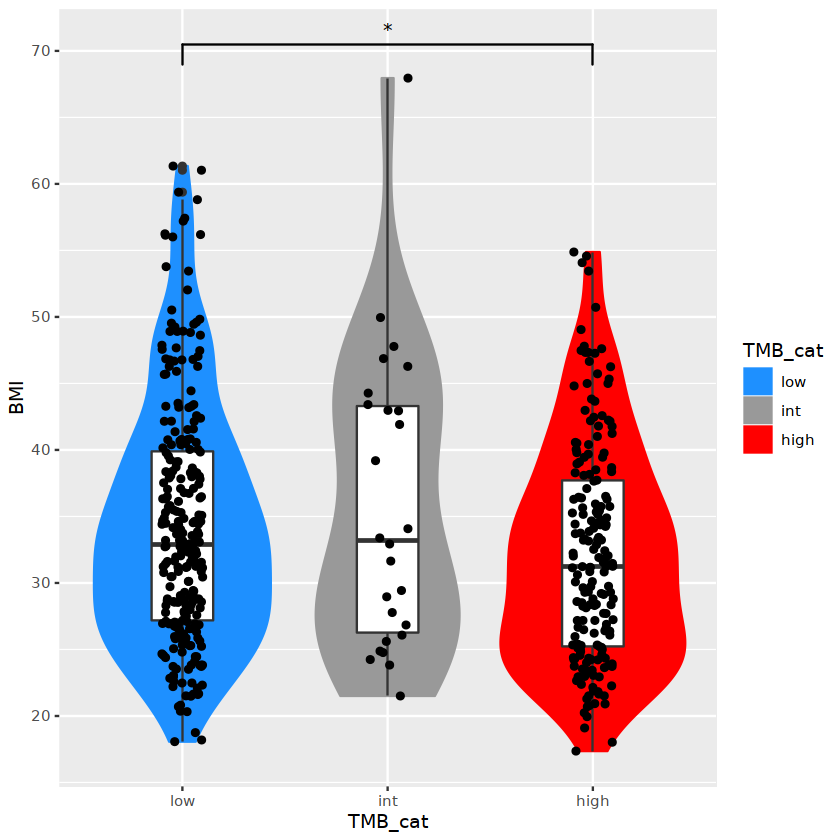

In [6]:
##test TMB and BMI categories
#metadata$TMB_cat <- as.factor(metadata$TMB_cat)
metadata$TMB_cat <- factor(metadata$TMB_cat, levels = c("low", "int", "high"))
ggplot(metadata, aes(x=TMB_cat, y=BMI), fill=TMB_cat) +
    geom_violin(aes(fill=TMB_cat, color=TMB_cat)) +
    scale_colour_manual(values = c("dodgerblue", "grey60", "red")) +
    scale_fill_manual(values = c("dodgerblue", "grey60", "red")) +
    geom_boxplot(width=0.3) +
    geom_jitter(position=position_jitter(0.1)) +
    geom_signif(comparisons = list(c("low","high")), map_signif_level=TRUE)
ggsave(paste0(PLOTDIR,"/TMB_cat-vs-BMI.pdf"))

Warning message:
“Removed 29 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 29 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 29 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 29 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


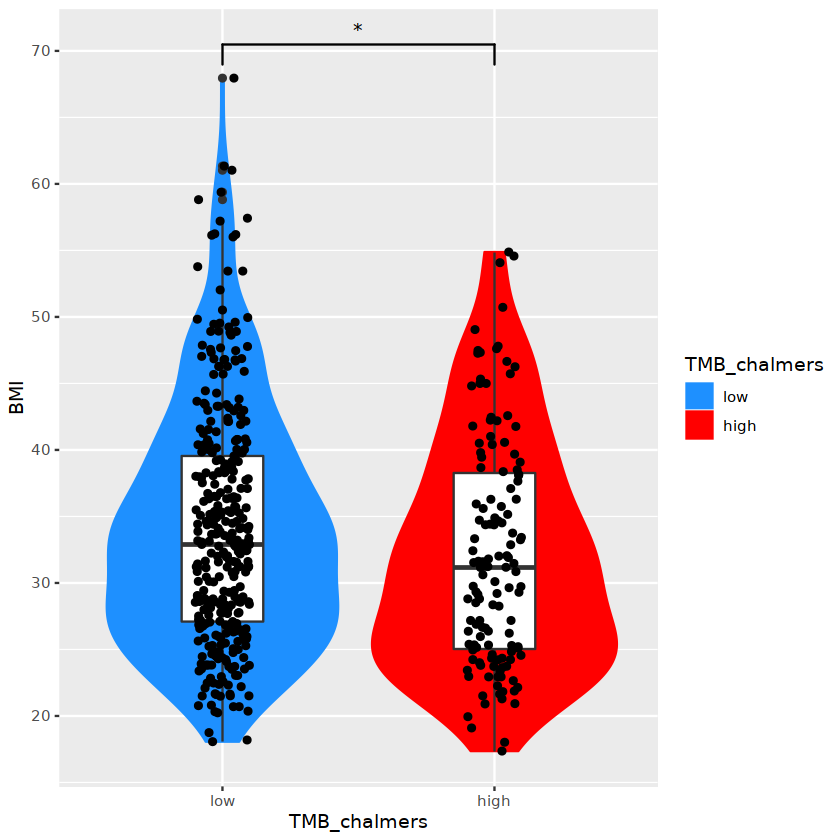

In [11]:
##test TMB 20 (Chalmers 2017 threshold) and BMI
metadata$TMB_chalmers <- factor(metadata$TMB_chalmers, levels = c("low", "high"))
ggplot(metadata, aes(x=TMB_chalmers, y=BMI), fill=TMB_chalmers) +
    geom_violin(aes(fill=TMB_chalmers, color=TMB_chalmers)) +
    scale_colour_manual(values = c("dodgerblue", "red")) +
    scale_fill_manual(values = c("dodgerblue", "red")) +
    geom_boxplot(width=0.3) +
    geom_jitter(position=position_jitter(0.1)) +
    geom_signif(comparisons = list(c("low","high")), map_signif_level=TRUE)
ggsave(paste0(PLOTDIR,"/TMB_chalmers-vs-BMI.pdf"))

Saving 6.67 x 6.67 in image



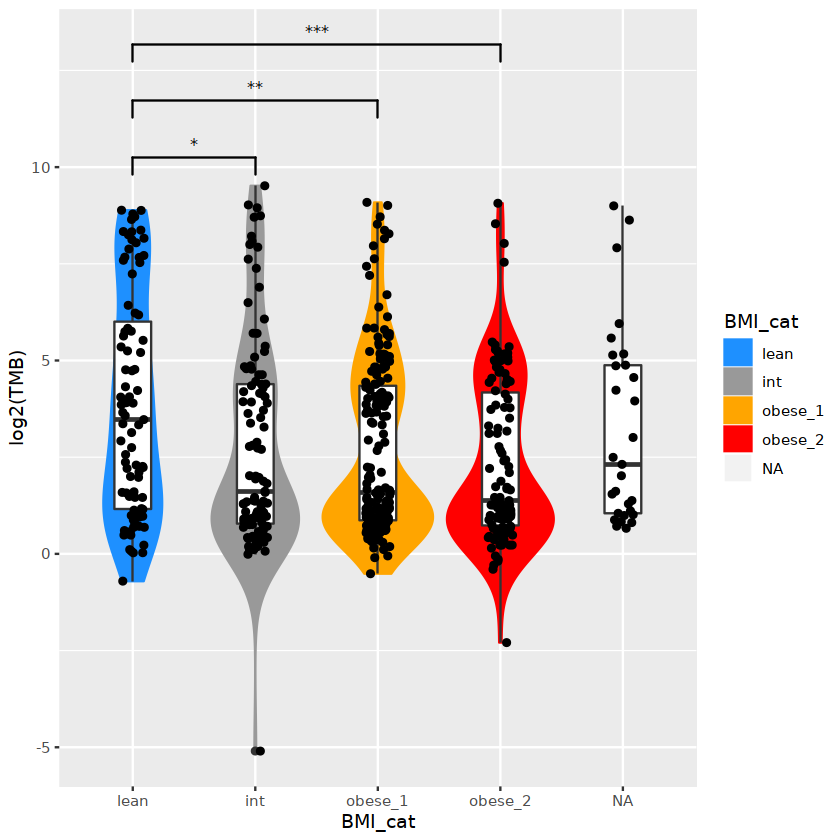

In [12]:
##test TMB and BMI_cats
metadata$BMI_cat <- factor(metadata$BMI_cat, levels = c("lean", "int", "obese_1", "obese_2", NA))
ggplot(metadata, aes(x=BMI_cat, y=log2(TMB)), fill=BMI_cat) +
    geom_violin(aes(fill=BMI_cat, color=BMI_cat)) +
    scale_colour_manual(values = c("dodgerblue", "grey60", "orange", "red", "pink")) +
    scale_fill_manual(values = c("dodgerblue", "grey60", "orange", "red", "pink")) +
    geom_boxplot(width=0.3) +
    geom_jitter(position=position_jitter(0.1)) +
    geom_signif(comparisons = list(c("lean","int"), c("lean","obese_1"), c("lean","obese_2")), map_signif_level=TRUE, , step_increase=0.1, textsize=3.2)
ggsave(paste0(PLOTDIR,"/BMI_cat-vs-log2TMB.pdf"))

In [ ]:
# ##test TMB and BMI
# ggplot(metadata, aes(x=BMI, y=log2(TMB))) +
#     geom_point() +
#     geom_smooth(method="lm", formula= y~x)
# ggsave(paste0(PLOTDIR,"/BMI-vs-log2TMB.pdf"))

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


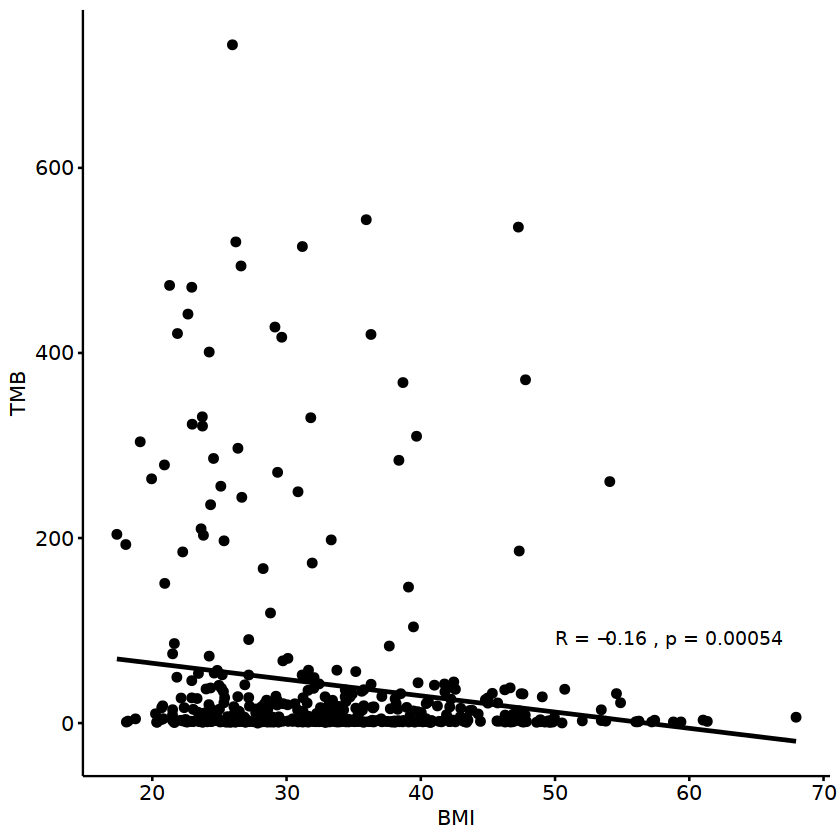

In [13]:
##TMB vs. BMI with regression line and p-value
ggscatter(metadata, x = "BMI", y = "TMB", add = "reg.line") +
  stat_cor(label.y = 90, label.x = 50)
ggsave(paste0(PLOTDIR,"/BMI-vs-TMB.reg-pval.pdf"))

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


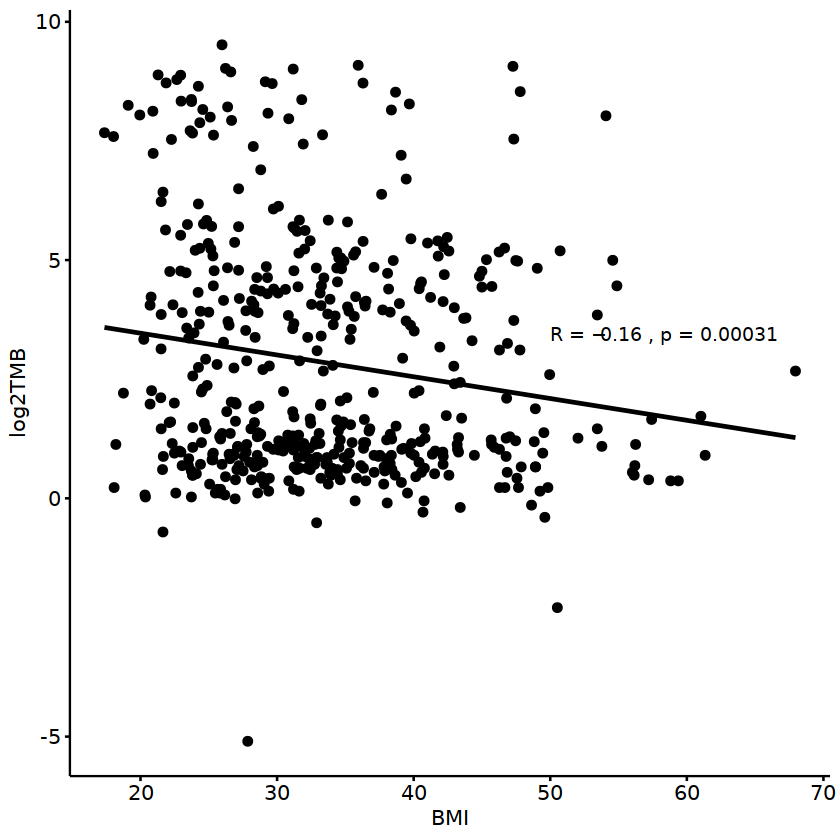

In [14]:
##log2TMB vs. BMI with regression line and p-value
metadata$log2TMB <- log2(metadata$TMB)
ggscatter(metadata, x = "BMI", y = "log2TMB", add = "reg.line") +
  stat_cor(label.y = 3.4, label.x = 50)
ggsave(paste0(PLOTDIR,"/BMI-vs-log2TMB.reg-pval.pdf"))

In [15]:
##6 immune signatures from pancancer atlas immune GDC API repo
##saved to sigList object containing two lists:
##ensembl_gene_id, external_gene_name
##each contain 5 lists, named by 4 letter codes _score

OUTPUT <- paste0(RDATDIR, "/dyck_et_al.7_sigs.RData")
if(!file.exists(OUTPUT)){

    PanImmune_GeneSet_Definitions_url <- "https://api.gdc.cancer.gov/data/6fcb2dbd-c339-402c-9c6b-098fae45e123"
    download(PanImmune_GeneSet_Definitions_url, dest=paste0(OUTDIR, "/pan_gene_sigs.tmp.xlsx"), mode="wb")
    pan_genes_defs <- suppressWarnings(read_xlsx(path=paste0(OUTDIR, "/pan_gene_sigs.tmp.xlsx"), sheet=3, skip=5)) %>%
                      dplyr::select(cluster=1, name=4) %>% dplyr::filter(!is.na(name)) %>%
                      add_row(cluster="Th1 cells", name="Th1 cells")
    pan_genes_set <- suppressWarnings(read_xlsx(path=paste0(OUTDIR, "/pan_gene_sigs.tmp.xlsx"), sheet=2)) %>%
                     dplyr::filter(SetName %in% pan_genes_defs$cluster)

    csfr_sig <- pan_genes_set %>% dplyr::filter(SetName %in% "CSF1_response") %>% dplyr::select(2) %>% unlist()
    liss_sig <- pan_genes_set %>% dplyr::filter(SetName %in% "LIexpression_score") %>% dplyr::select(2) %>% unlist()
    tgfb_sig <- pan_genes_set %>% dplyr::filter(SetName %in% "TGFB_score_21050467") %>% dplyr::select(2) %>% unlist() 
    ifng_sig <- pan_genes_set %>% dplyr::filter(SetName %in% "Module3_IFN_score") %>% dplyr::select(2) %>% unlist() 
    csru_sig <- pan_genes_set %>% dplyr::filter(SetName %in% "CHANG_CORE_SERUM_RESPONSE_UP") %>% dplyr::select(2) %>% unlist()
    th1c_sig <- pan_genes_set %>% dplyr::filter(SetName %in% "Th1 cells") %>% dplyr::select(2) %>% unlist()
    dyck_sig <- c("CD8", "IFNG", "PRF1", "GZMB", "MKI67", "SLC7A5", "NCR1", "PDCD1", "CD274")
    sigList <- NULL
    sigList[["external_gene_name"]] <- list(csfr_sig, liss_sig, tgfb_sig, ifng_sig, csru_sig, th1c_sig, dyck_sig)
    names(sigList[["external_gene_name"]]) <- c("CSFR_score", "LISS_score", "TGFB_score", "IFNG_score", "CSRU_score", "T1CL_score", "DYCK_score")
    
    save(sigList, pan_genes_defs, pan_genes_set, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}

In [16]:
##signature rescores
##this uses same genesets and method (ssGSEA in GSVA package) 
##used in pancancer immune landscape paper doi: 10.1016/j.immuni.2018.03.023
OUTPUT <- paste0(RDATDIR, "/dyck_et_al.log2tpm_gsva_sigs.RData")
if(!file.exists(OUTPUT)){
    
    ##map sigList to ensembl_gene_id
    sigList[["ensembl_gene_id"]] <- lapply(sigList[["external_gene_name"]], function(f){
        maps <- as_tibble(tx2gene) %>% 
                dplyr::filter(external_gene_name %in% f) %>%
                dplyr::select(ensembl_gene_id) %>% unlist() %>% unname() %>% unique()
        return(maps)
    })
    
    id2gene_sigs <- as_tibble(tx2gene) %>% 
                    dplyr::filter(external_gene_name %in% unique(unlist(sigList))) %>%
                    dplyr::select(ensembl_gene_id, external_gene_name) %>% 
                    unique()
    
    ##gsva; NB using log2tpm and Poisson dist as per manual 02/05/19
    gsva_log2tpms <- pivot_wider(data = so$obs_norm, id_cols = target_id, names_from = sample, values_from = tpm) %>% 
                     dplyr::rename(ensembl_gene_id = target_id) %>%
                     dplyr::mutate_if(is.numeric, log2)
    gsva_log2tpms_mat <- gsva_log2tpms %>% as.data.frame() %>% column_to_rownames("ensembl_gene_id") %>% as.matrix()
    gsva_ssgsea_scores <- gsva(expr=gsva_log2tpms_mat, gset.idx.list=sigList[["ensembl_gene_id"]], method="ssgsea") %>% t() %>% as_tibble(rownames="sample")
    
    colnames(gsva_ssgsea_scores) <- gsub("_score", "_rescore", colnames(gsva_ssgsea_scores)) 
    sigs_metadata <- join(metadata, gsva_ssgsea_scores, by="sample") %>%
                     dplyr::mutate(T1CL_score = T1CL_rescore,
                                   DYCK_score = DYCK_rescore)
    
    ##some genes have several annotations, we take highest expressed
    obs_norm_sigs <- so$obs_norm %>% 
                     dplyr::rename(ensembl_gene_id = target_id) %>%
                     dplyr::filter(ensembl_gene_id %in% id2gene_sigs$ensembl_gene_id) %>%
                     left_join(id2gene_sigs, .)
    
    hew <- highest_exp_wide(obs_norm_sigs, name_col="external_gene_name", id_col="ensembl_gene_id", value_col="tpm")

    obs_norm_sigs <- obs_norm_sigs %>% dplyr::filter(ensembl_gene_id %in% hew$ensembl_gene_id) %>%
                     dplyr::mutate(log2tpm = log2(tpm)) %>%
                     left_join(., sigs_metadata, by="sample")
    
    save(sigList, id2gene_sigs, obs_norm_sigs, sigs_metadata, gsva_log2tpms, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}
length(unique(obs_norm_sigs$sample))

[1] 513

In [17]:
##BMI vs. signature scores, any TMB class
SUBPLOTDIR <- paste0(PLOTDIR,"/sigs_vs_BMI/")
dir.create(SUBPLOTDIR, recursive=TRUE, showWarnings=FALSE)
lapply(names(sigList[[1]]), function(n){
    ggscatter(sigs_metadata, x = "BMI", y = n, add = "reg.line") +
       stat_cor(label.x = 50, label.y = max(sigs_metadata[,n]))
    ggsave(paste0(SUBPLOTDIR,"/", n, ".vs_BMI.pdf"))
})


Saving 6.67 x 6.67 in image

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 29 rows conta

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

In [18]:
##per TMB class (low, int, high), BMI vs. signature scores
SUBPLOTDIR <- paste0(PLOTDIR,"/TMB_cat-sigs_vs_BMI/")
dir.create(SUBPLOTDIR, recursive=TRUE, showWarnings=FALSE)
lapply(levels(sigs_metadata$TMB_cat), function(f){
   tmb_metadata <- sigs_metadata %>% dplyr::filter(TMB_cat %in% f)
   lapply(names(sigList[[1]]), function(n){
        ggscatter(tmb_metadata, x = "BMI", y = n, add = "reg.line") +
           stat_cor(label.x = 40, label.y = max(tmb_metadata[,n]))
        ggsave(paste0(SUBPLOTDIR, "/TMB_", f, ".", n, ".vs_BMI.pdf"))
   })
})

Saving 6.67 x 6.67 in image

Warning message:
“Removed 12 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 12 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 12 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 12 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 12 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 12 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 12 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 12 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 12 rows conta

[[1]]
[[1]][[1]]
NULL

[[1]][[2]]
NULL

[[1]][[3]]
NULL

[[1]][[4]]
NULL

[[1]][[5]]
NULL

[[1]][[6]]
NULL

[[1]][[7]]
NULL


[[2]]
[[2]][[1]]
NULL

[[2]][[2]]
NULL

[[2]][[3]]
NULL

[[2]][[4]]
NULL

[[2]][[5]]
NULL

[[2]][[6]]
NULL

[[2]][[7]]
NULL


[[3]]
[[3]][[1]]
NULL

[[3]][[2]]
NULL

[[3]][[3]]
NULL

[[3]][[4]]
NULL

[[3]][[5]]
NULL

[[3]][[6]]
NULL

[[3]][[7]]
NULL

In [19]:
table(sigs_metadata[["TCGA Subtype"]])



          NA        UCEC. UCEC.CN_HIGH  UCEC.CN_LOW     UCEC.MSI    UCEC.POLE 
           1            7          159          144          123           79 

In [20]:
##per histological_type, BMI vs. signature scores
SUBPLOTDIR <- paste0(PLOTDIR,"/histological_type-sigs_vs_BMI/")
dir.create(SUBPLOTDIR, recursive=TRUE, showWarnings=FALSE)
sigs_metadata$histological_type <- factor(sigs_metadata$histological_type, levels = c("Endometrioid endometrial adenocarcinoma", "Mixed serous and endometrioid", "Serous endometrial adenocarcinoma"))
lapply(levels(sigs_metadata$histological_type), function(f){
   hist_metadata <- sigs_metadata %>% dplyr::filter(histological_type %in% f)
   lapply(names(sigList[[1]]), function(n){
        ggscatter(hist_metadata, x = "BMI", y = n, add = "reg.line") +
           stat_cor(label.x = 40, label.y = max(hist_metadata[,n])) +
           ggtitle(f)
        ggsave(paste0(SUBPLOTDIR, "/hist_type-", f, ".", n, ".vs_BMI.pdf"))
   })
})

Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 18 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 18 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 18 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 18 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 18 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 18 rows conta

[[1]]
[[1]][[1]]
NULL

[[1]][[2]]
NULL

[[1]][[3]]
NULL

[[1]][[4]]
NULL

[[1]][[5]]
NULL

[[1]][[6]]
NULL

[[1]][[7]]
NULL


[[2]]
[[2]][[1]]
NULL

[[2]][[2]]
NULL

[[2]][[3]]
NULL

[[2]][[4]]
NULL

[[2]][[5]]
NULL

[[2]][[6]]
NULL

[[2]][[7]]
NULL


[[3]]
[[3]][[1]]
NULL

[[3]][[2]]
NULL

[[3]][[3]]
NULL

[[3]][[4]]
NULL

[[3]][[5]]
NULL

[[3]][[6]]
NULL

[[3]][[7]]
NULL

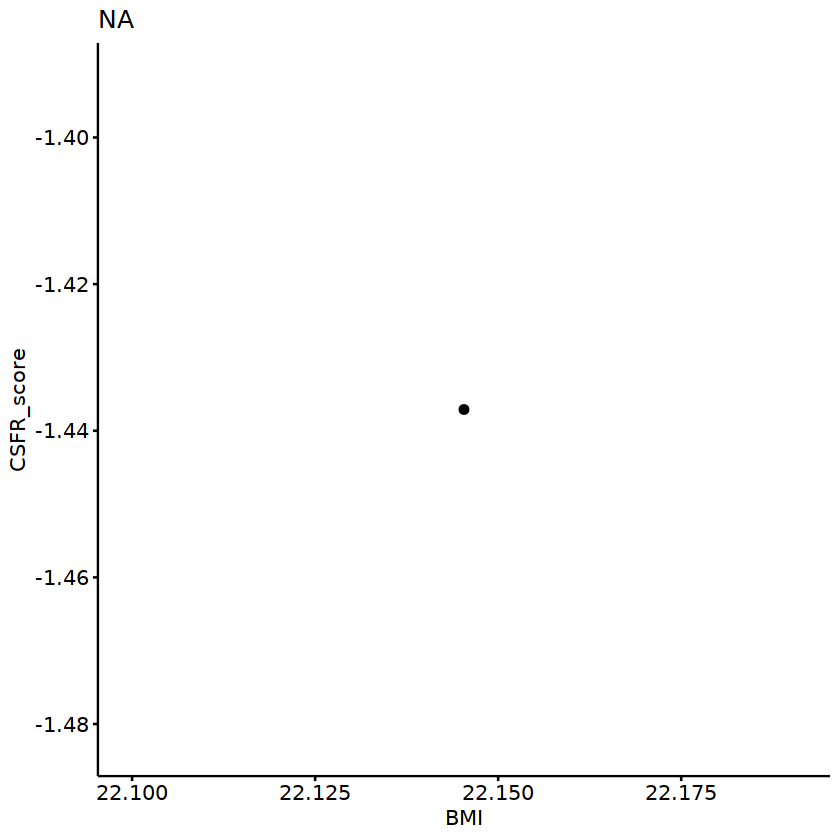

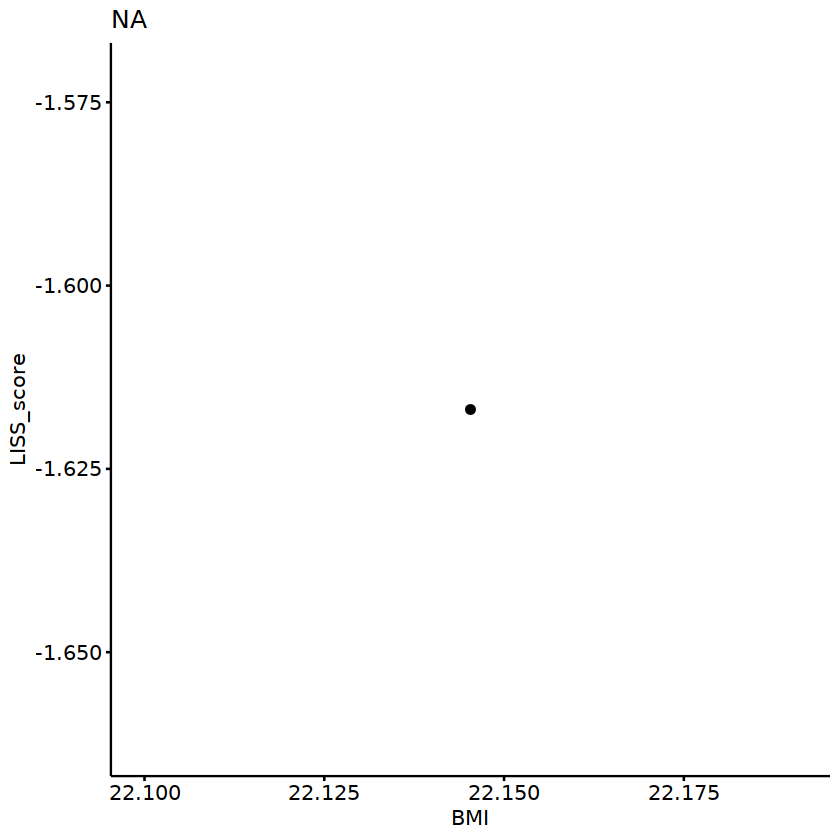

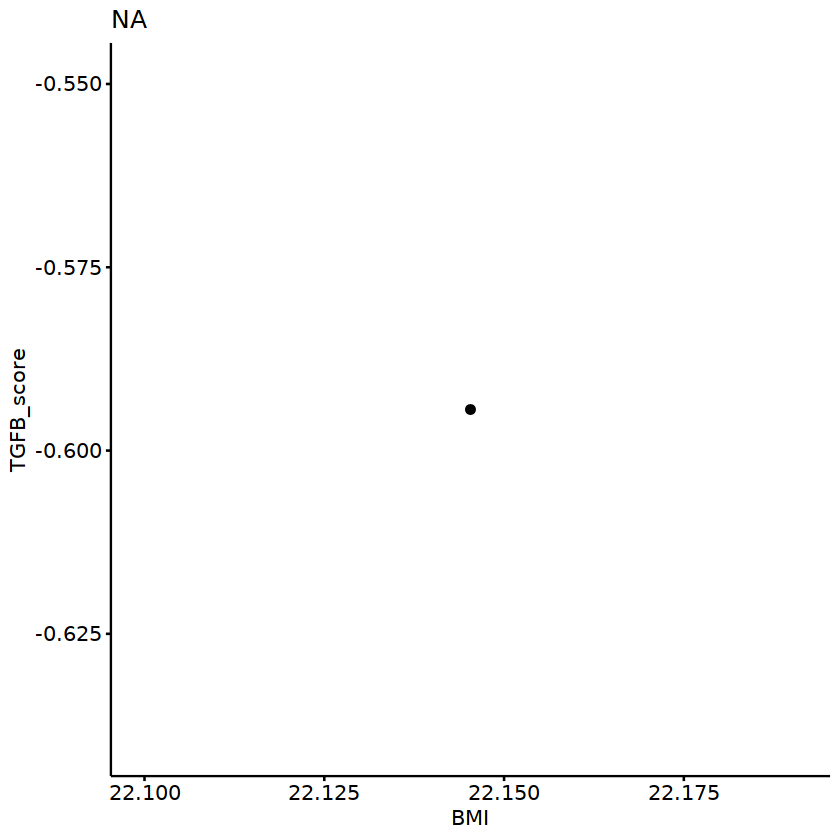

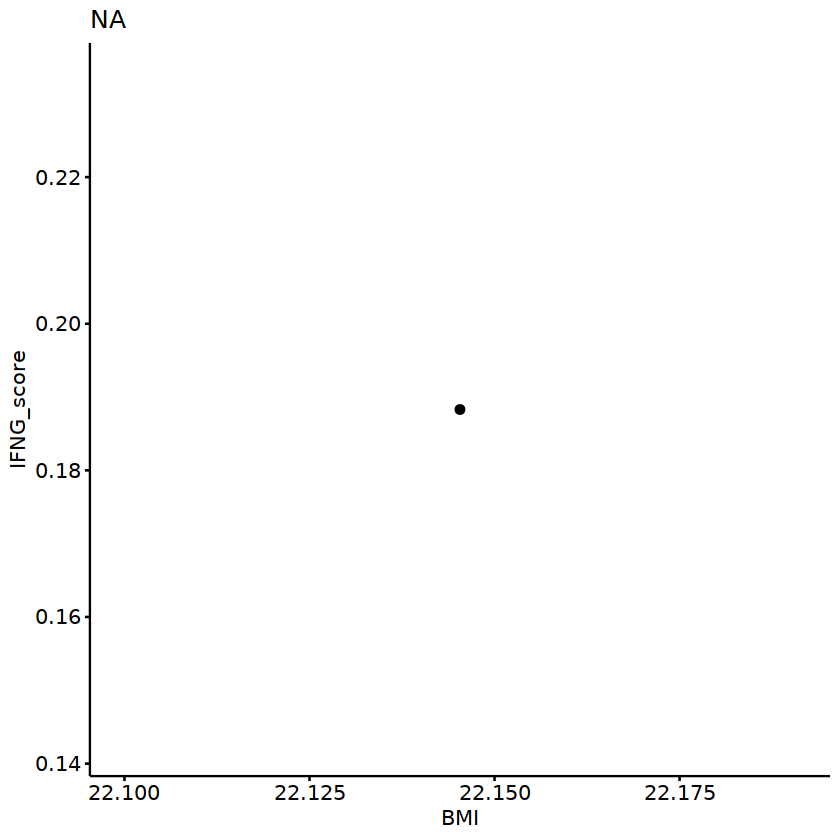

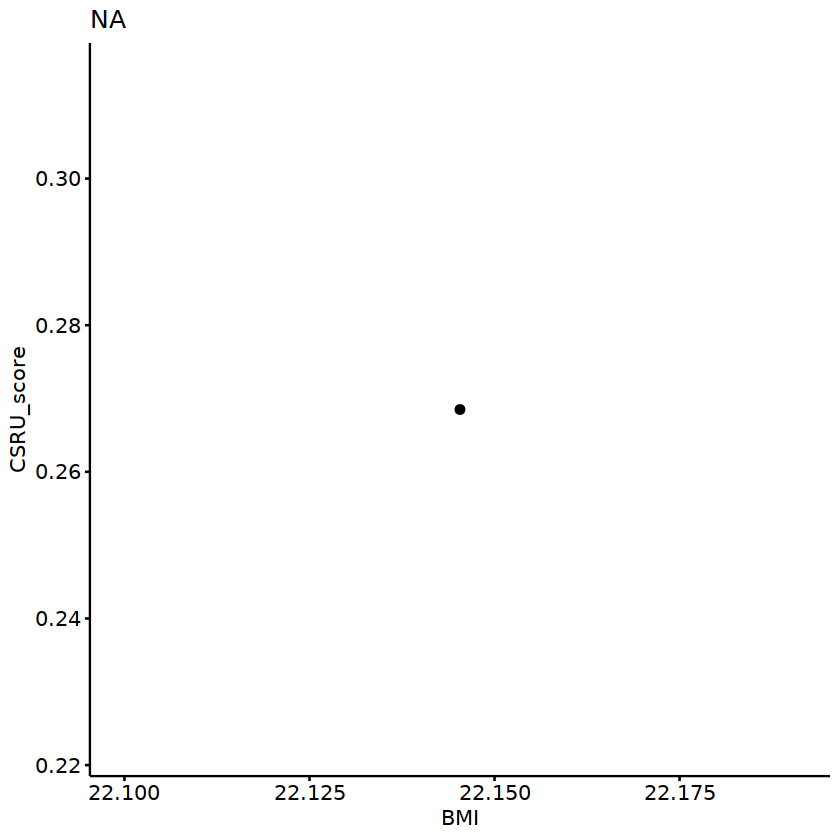

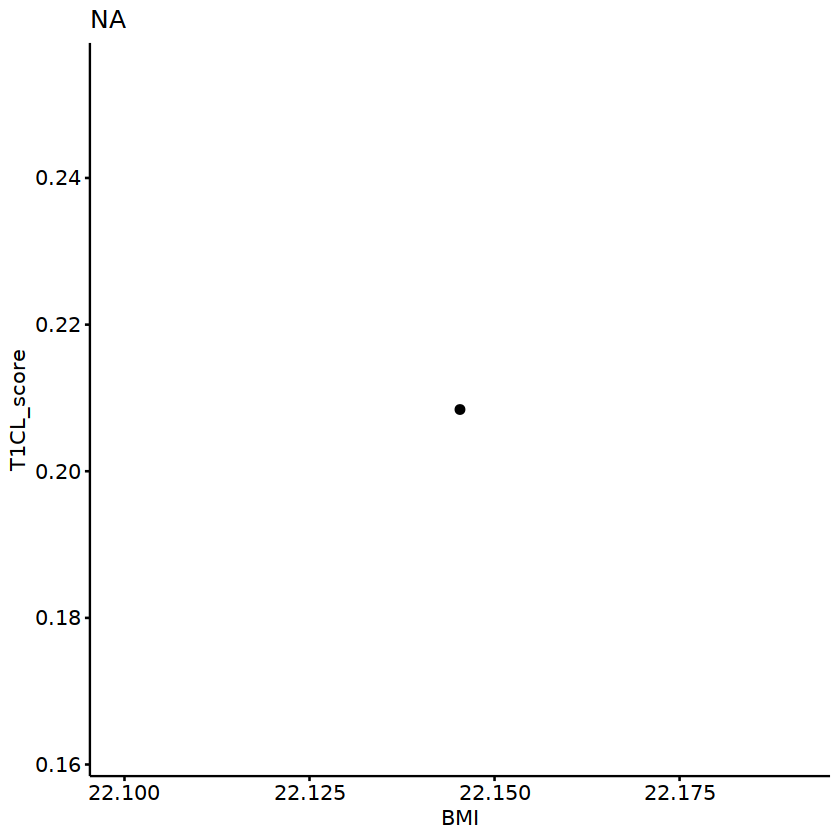

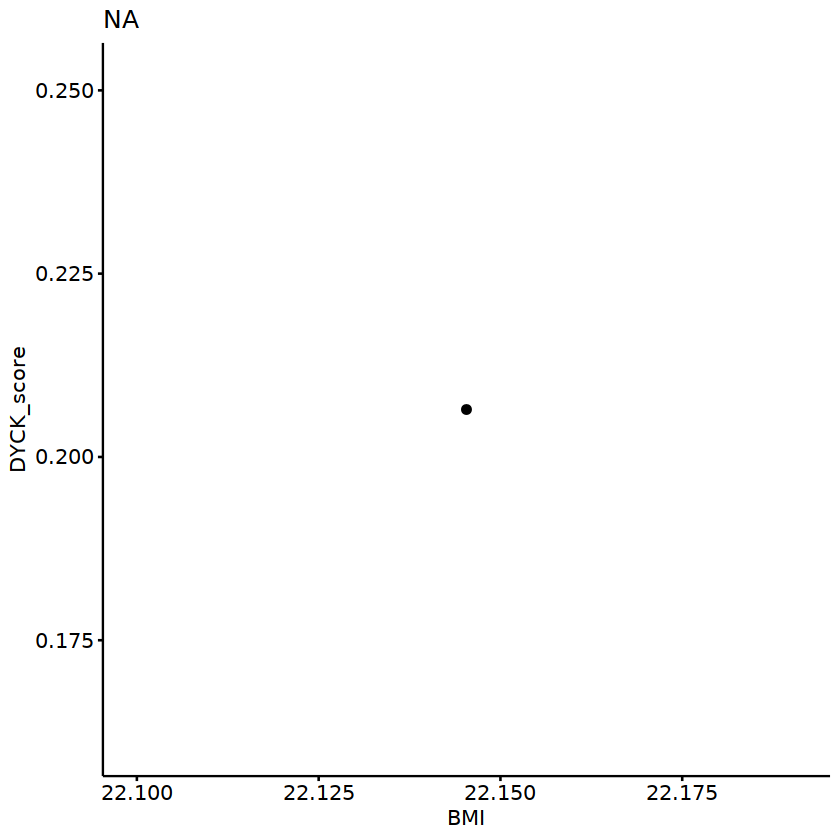

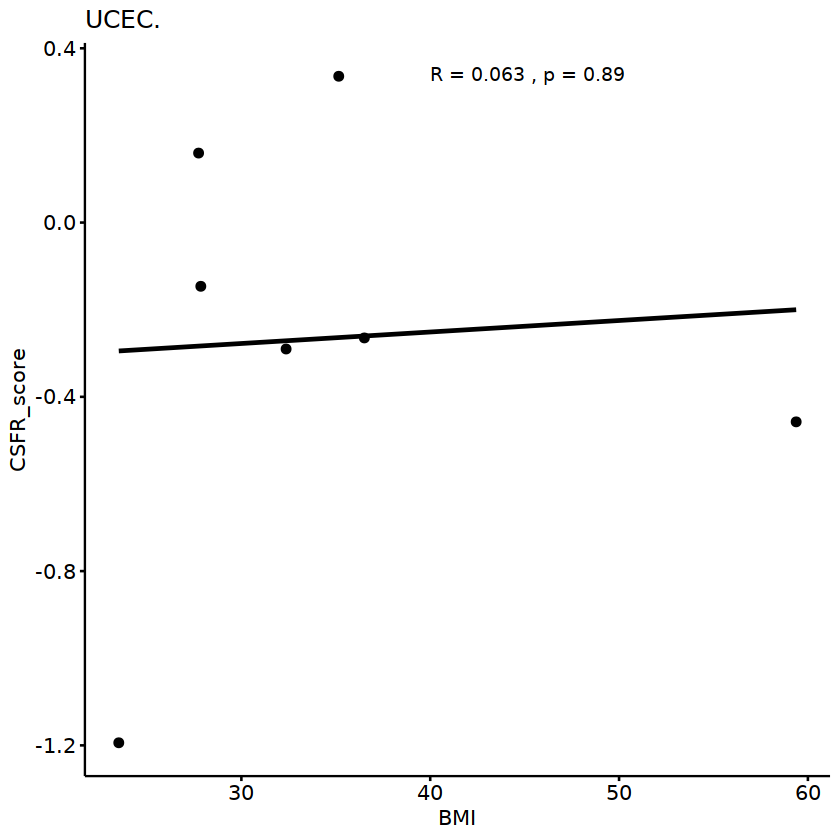

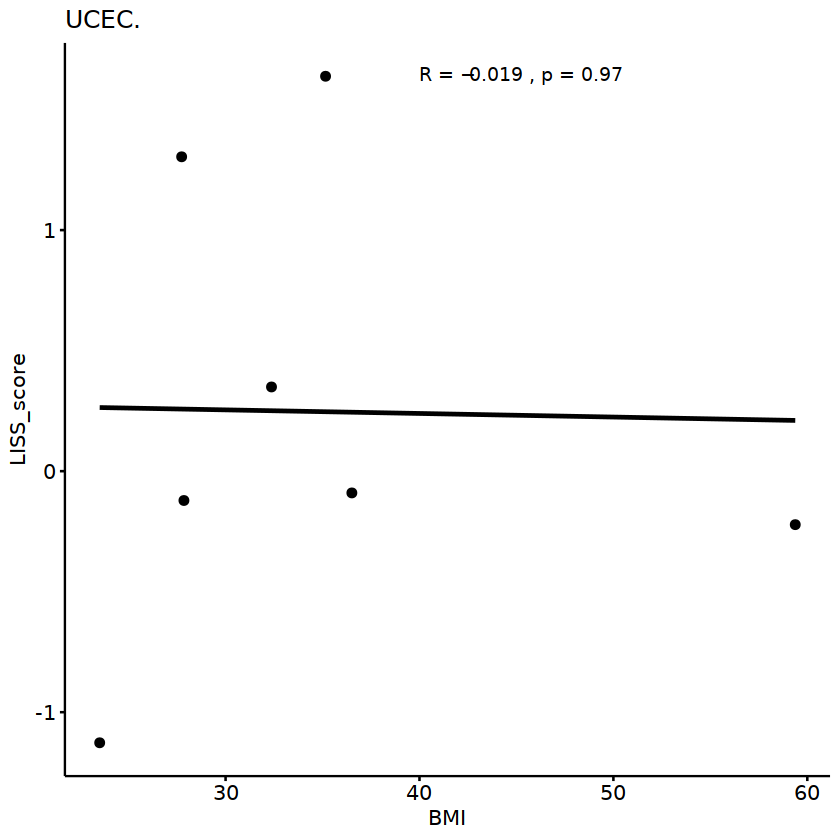

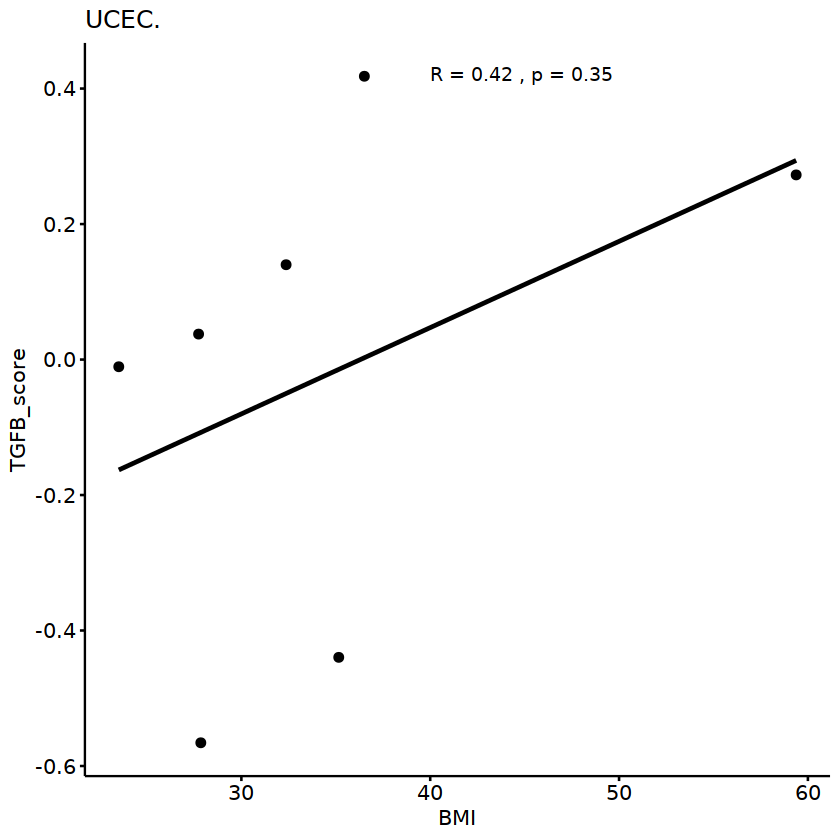

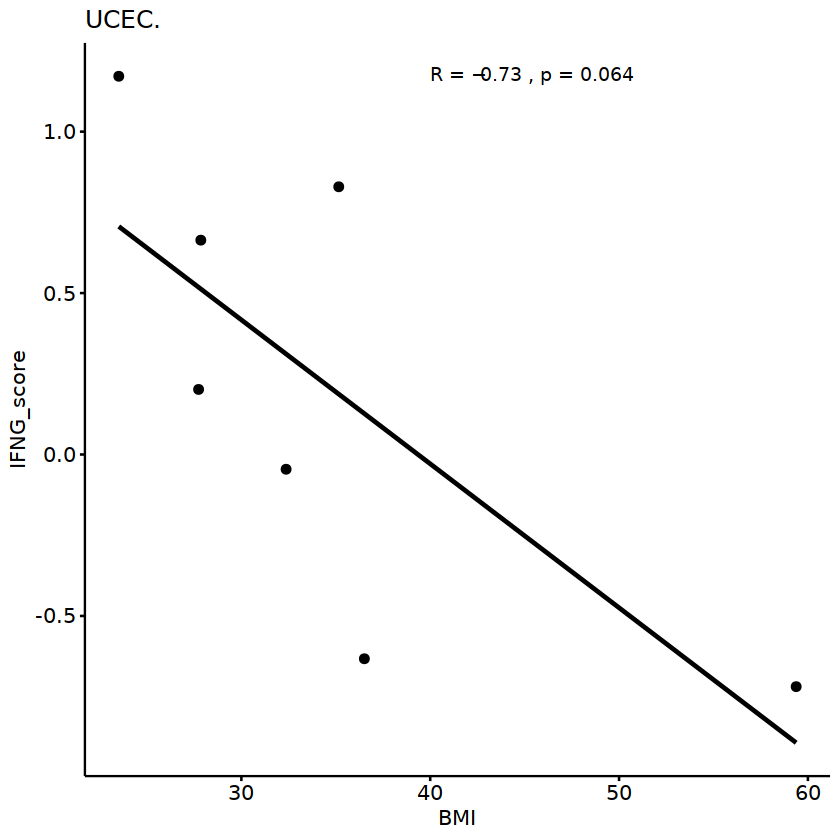

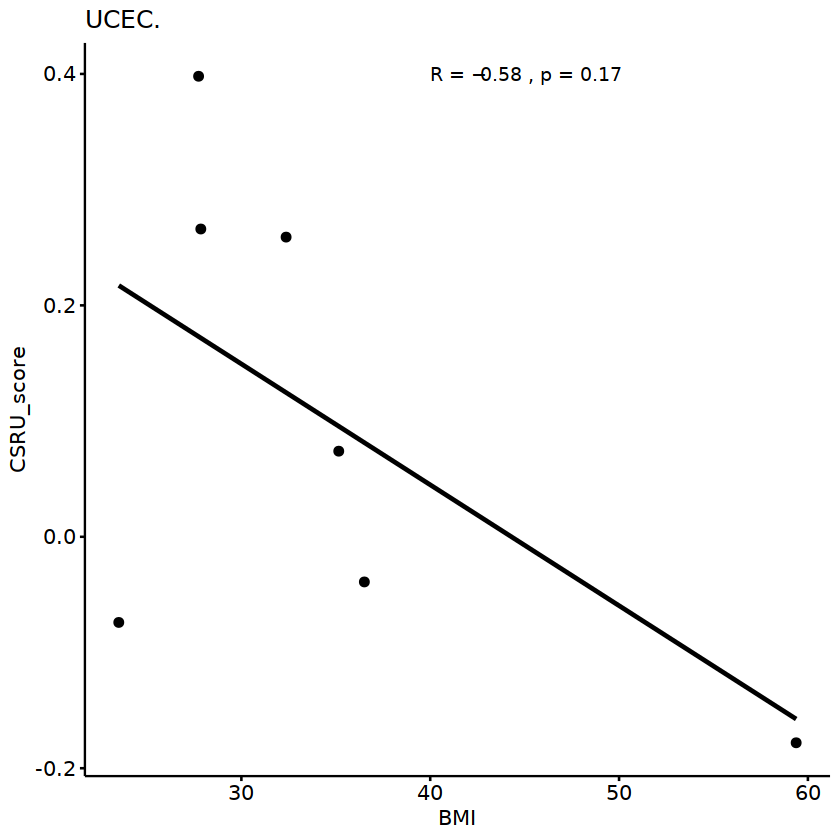

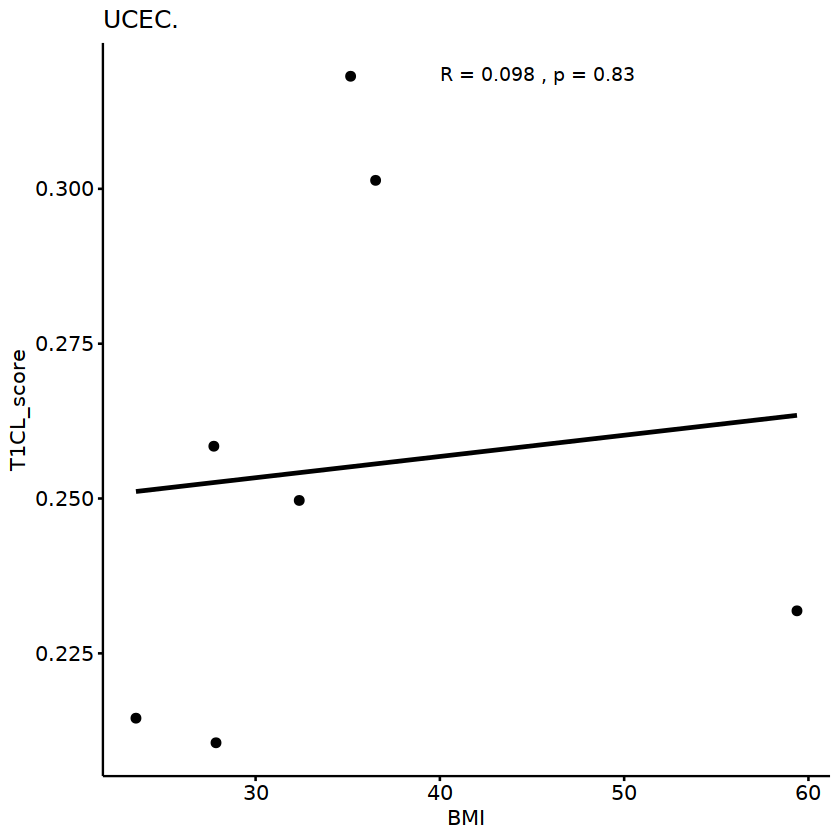

Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 13 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”


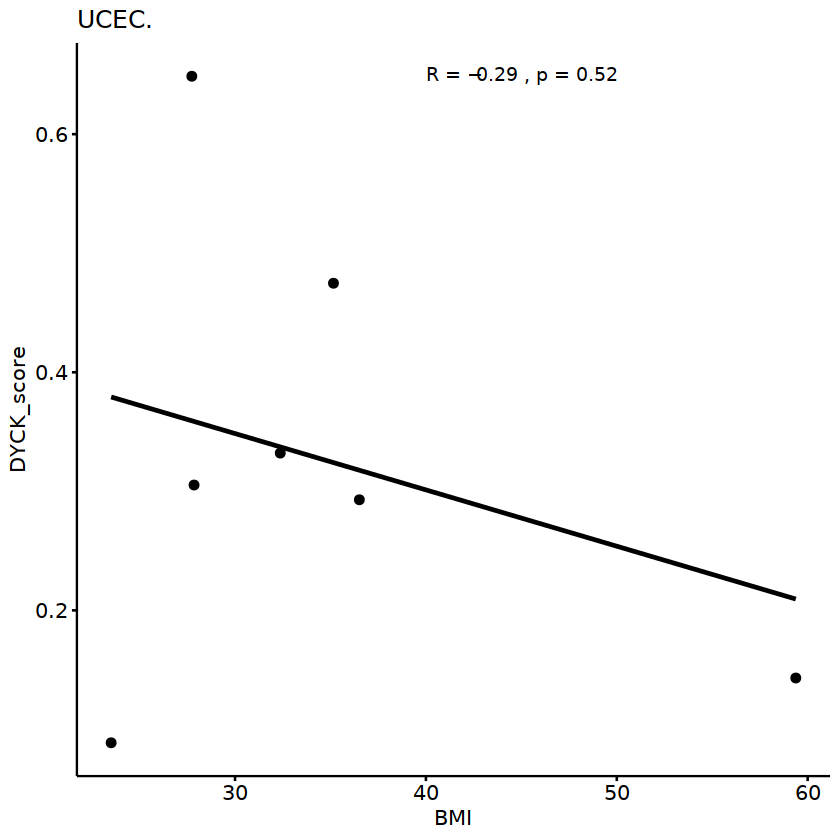

Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 13 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”


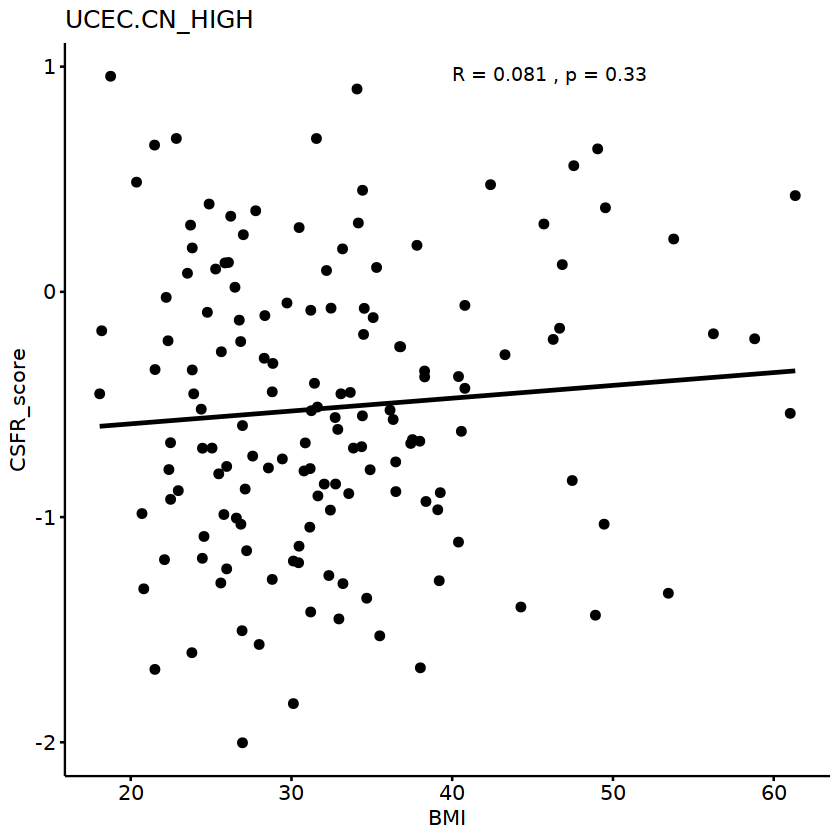

Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 13 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”


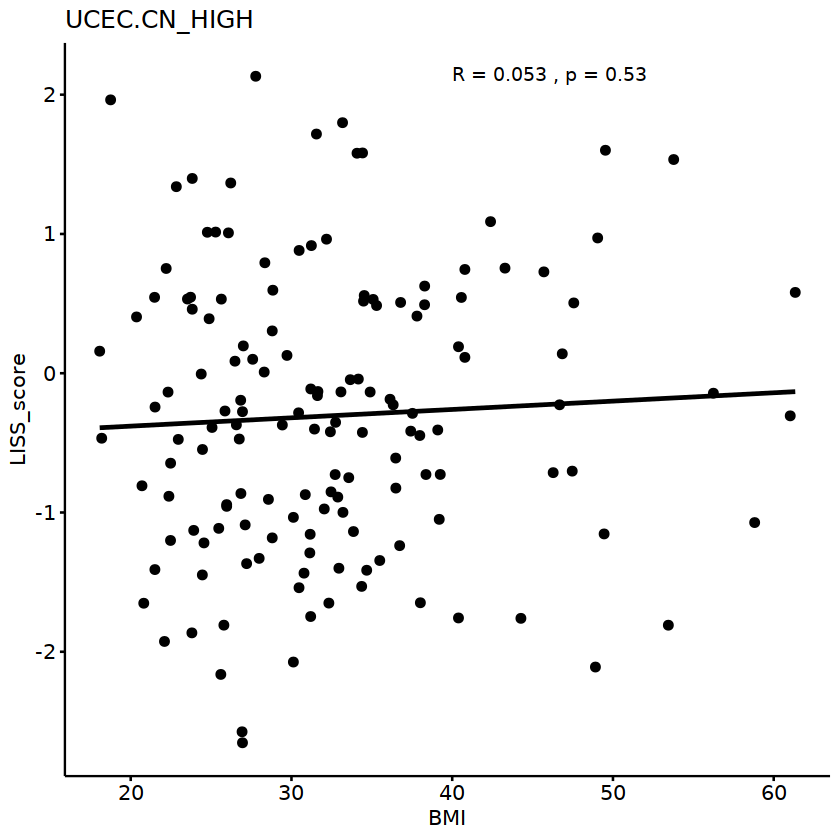

Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 13 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”


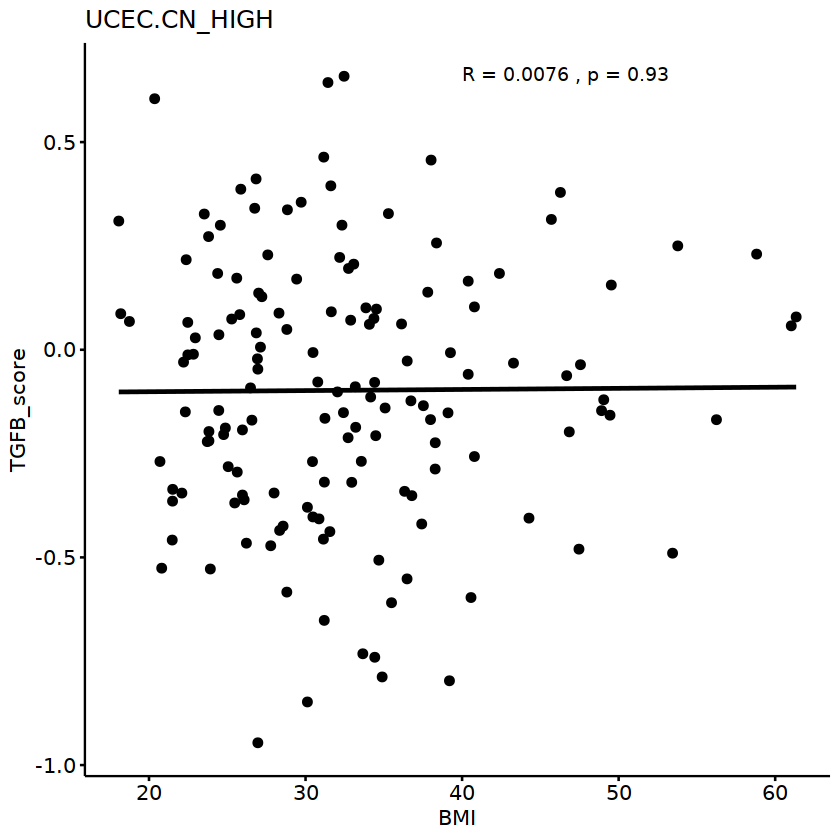

Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 13 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”


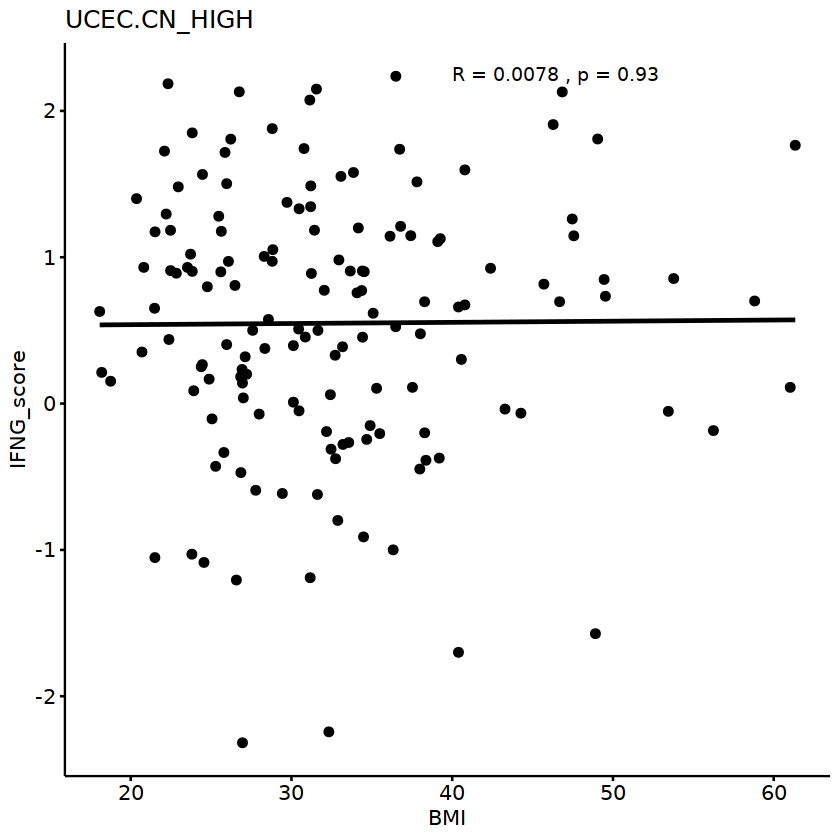

Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 13 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”


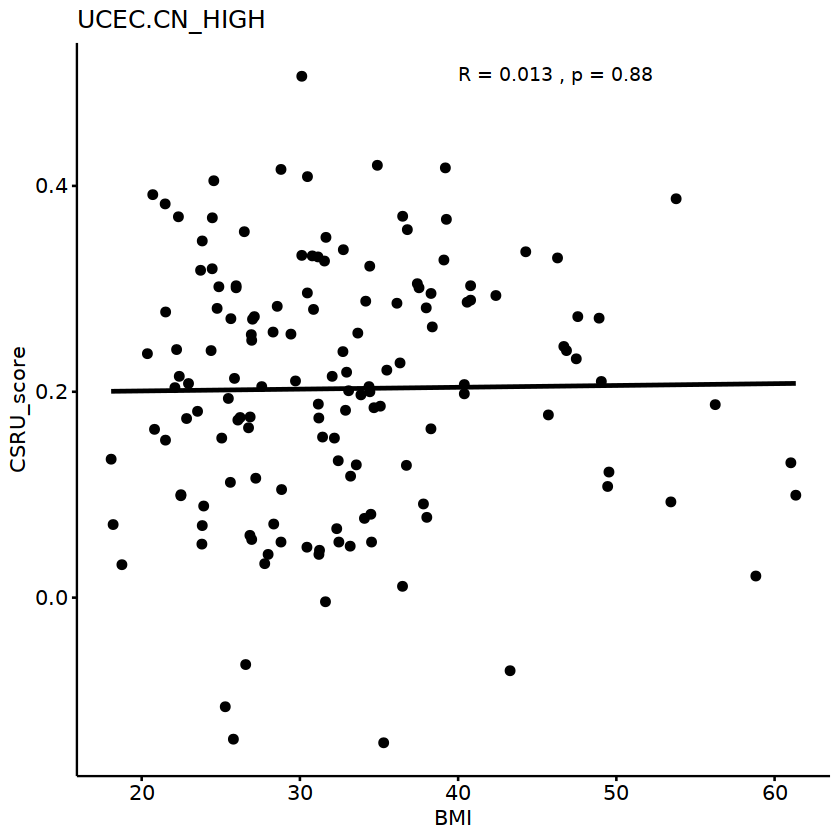

Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 13 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”


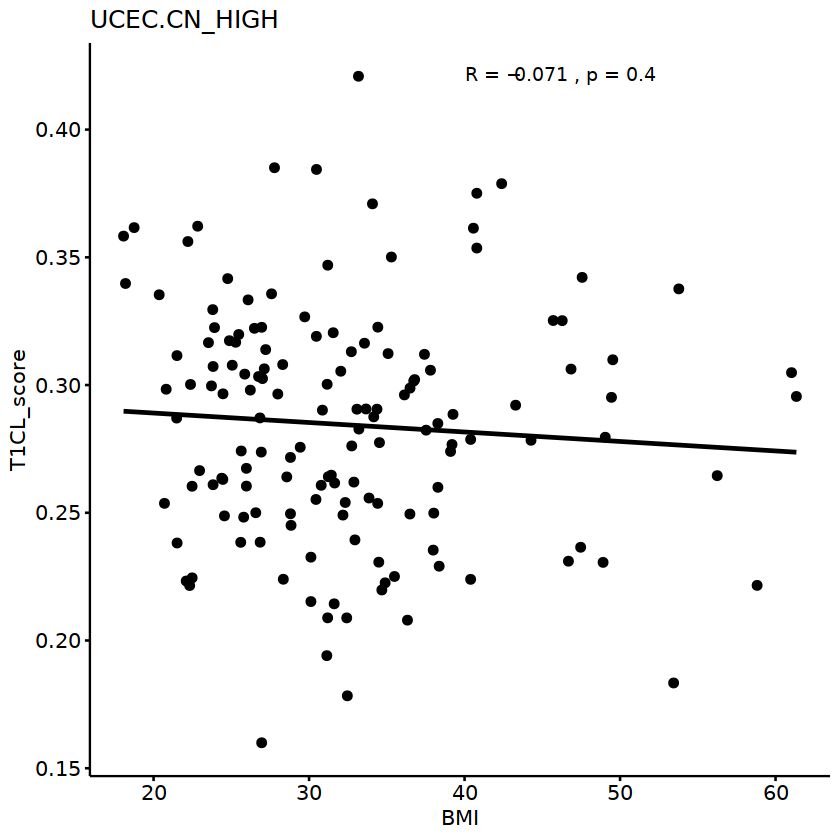

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 5 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


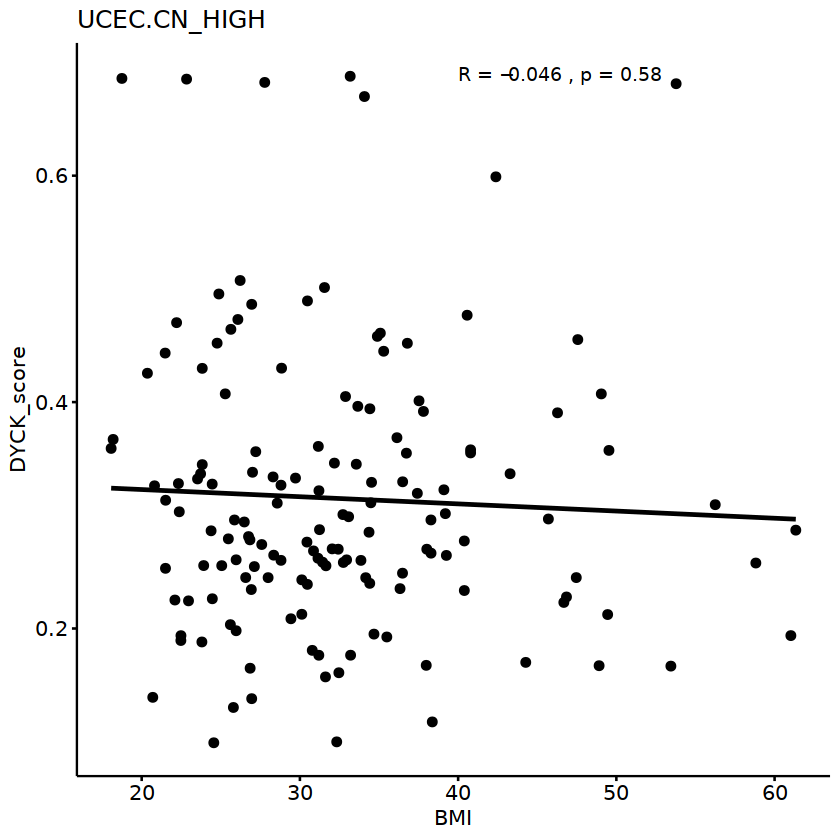

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 5 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


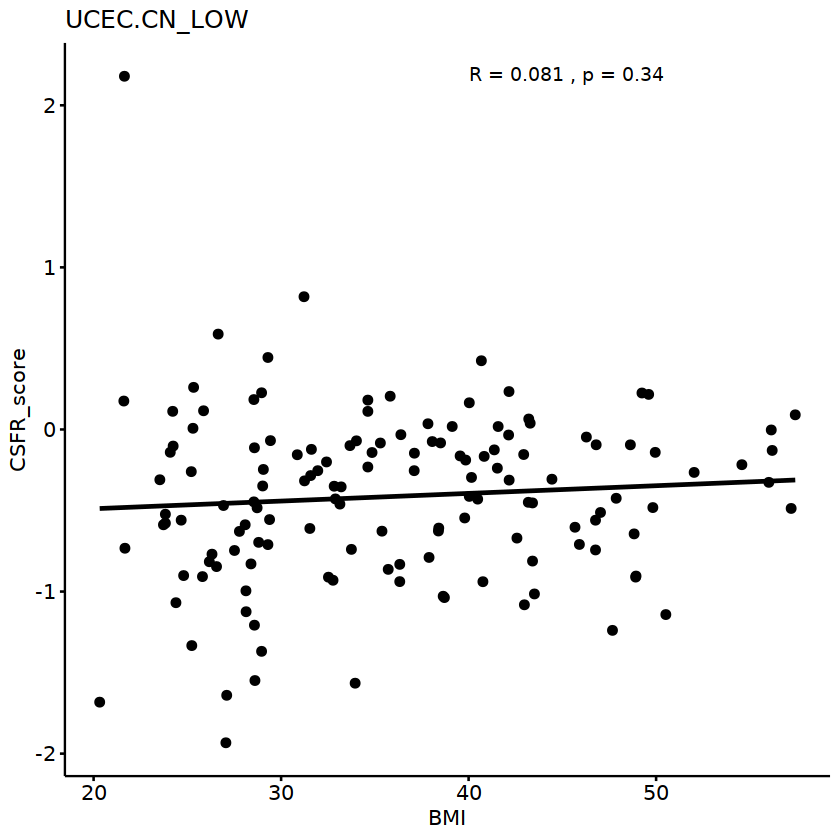

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 5 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


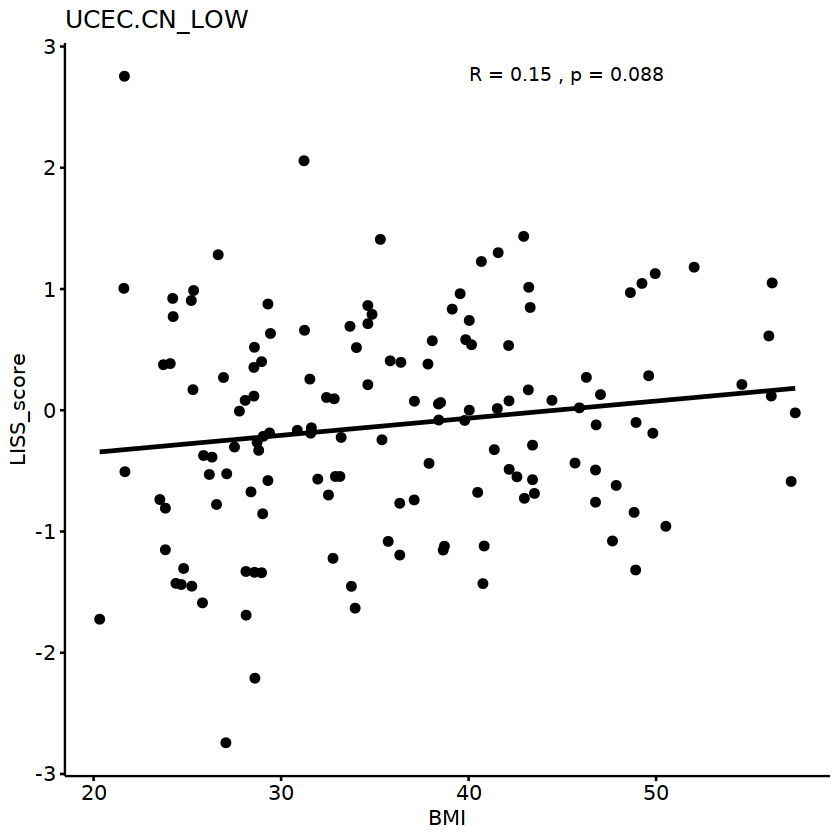

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 5 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


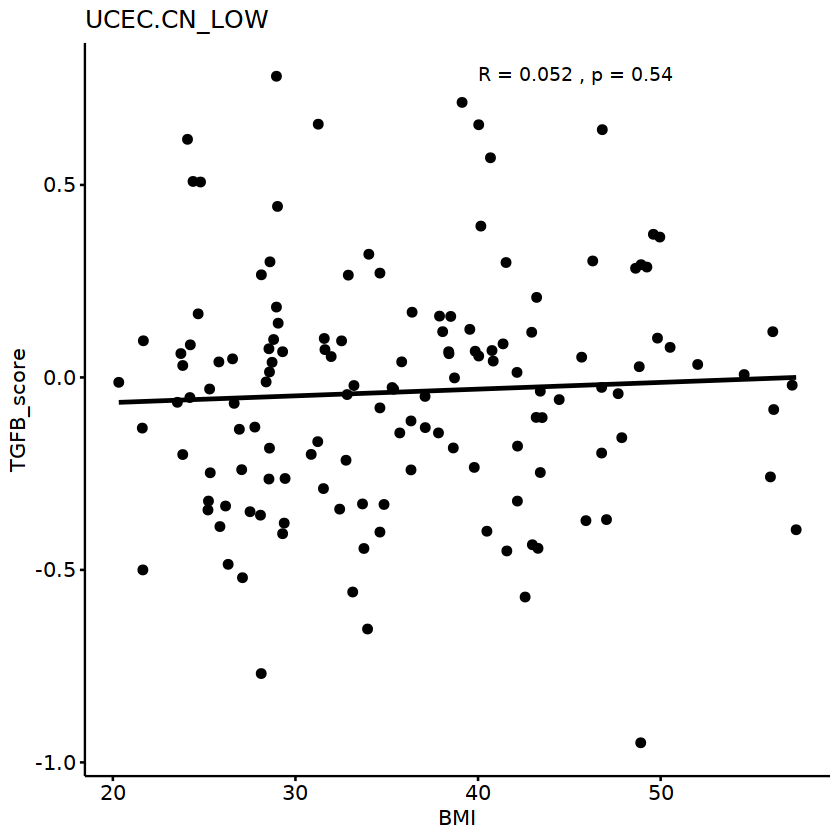

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 5 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


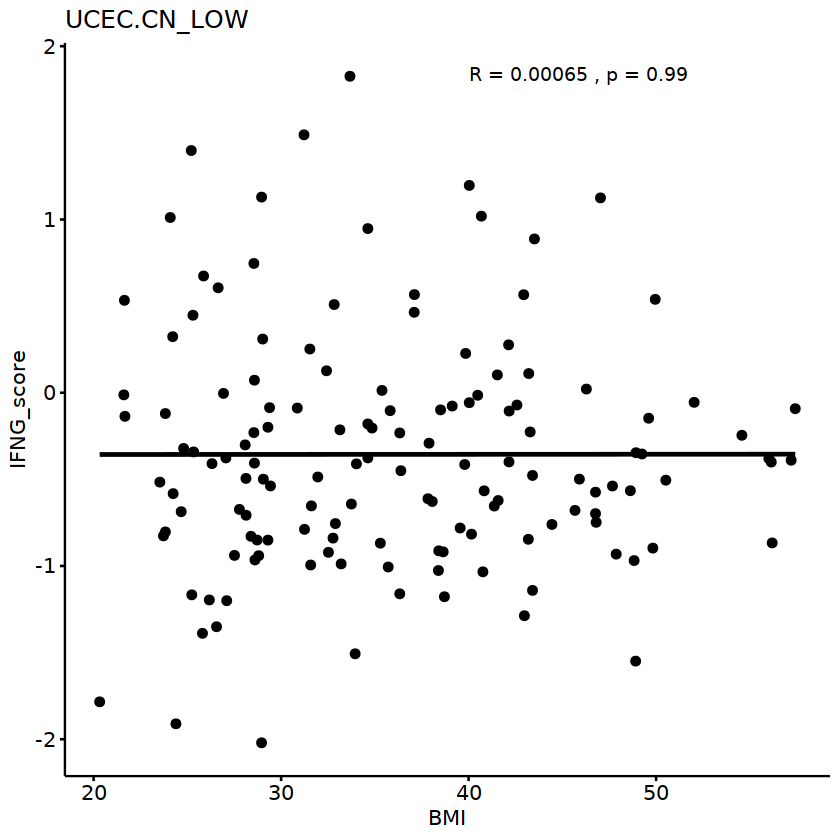

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 5 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


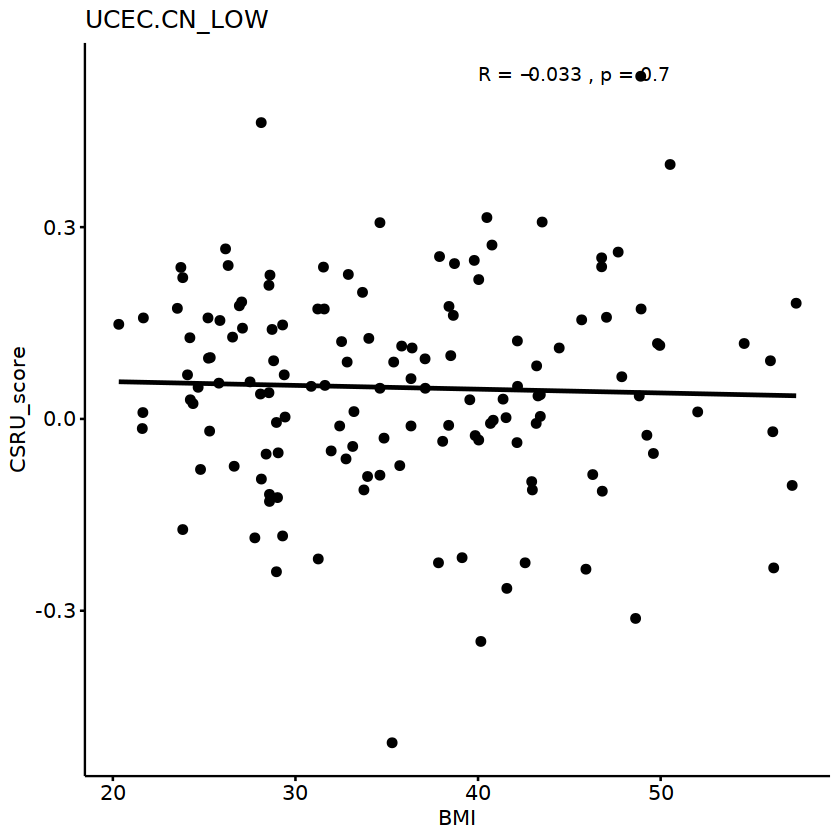

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 5 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


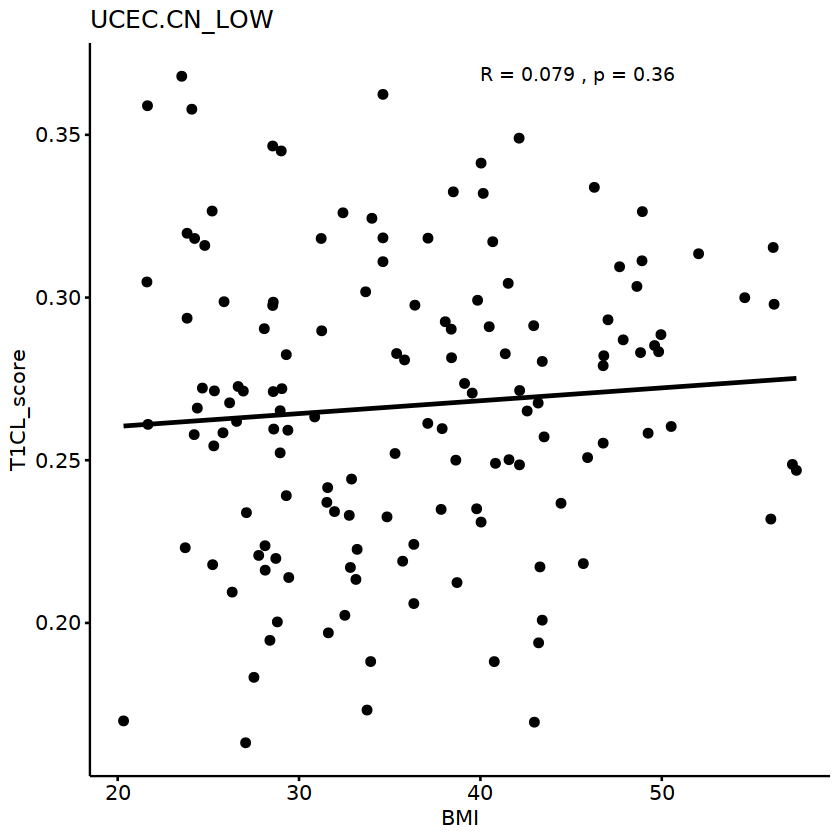

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


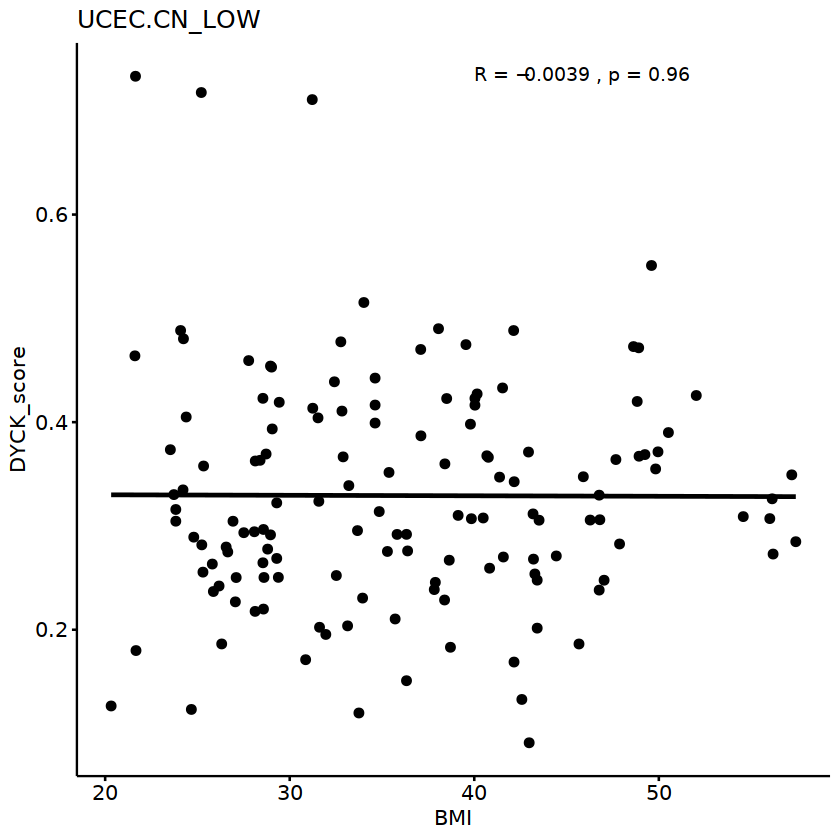

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


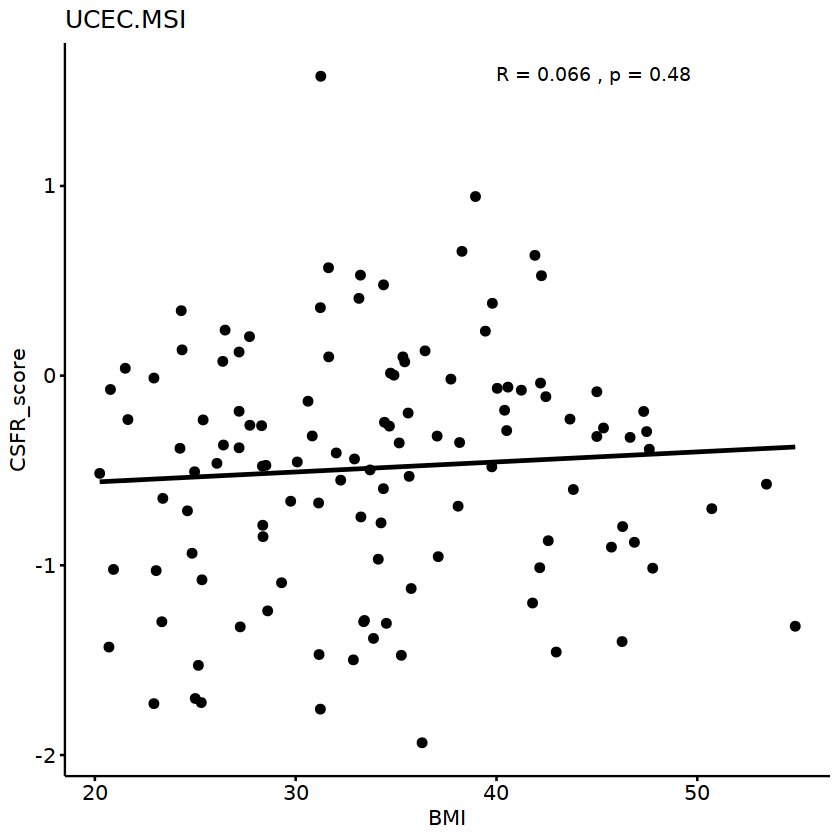

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


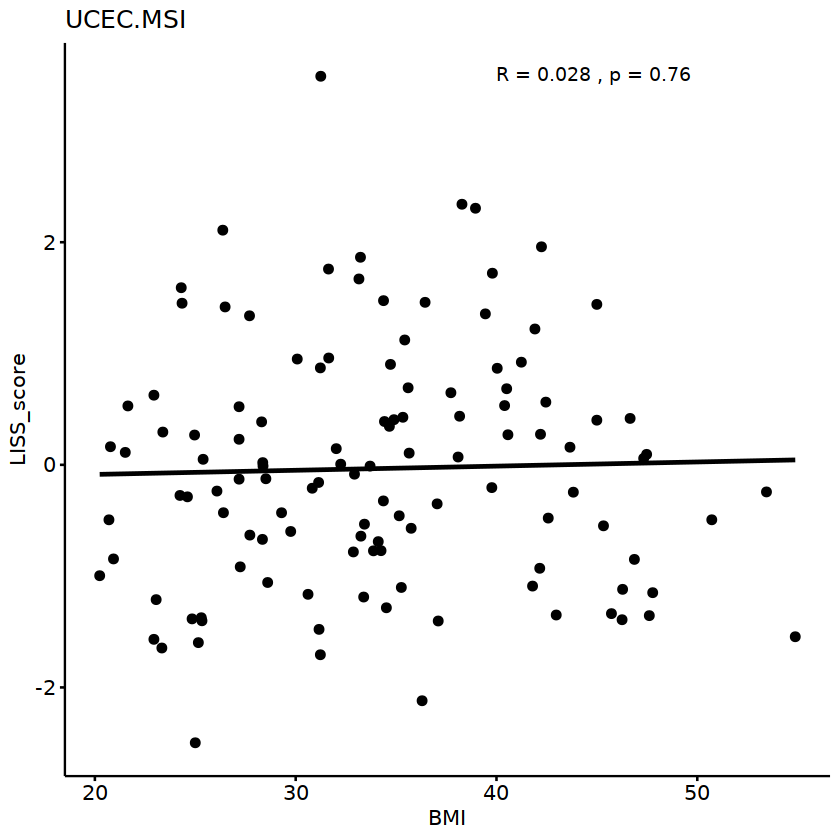

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


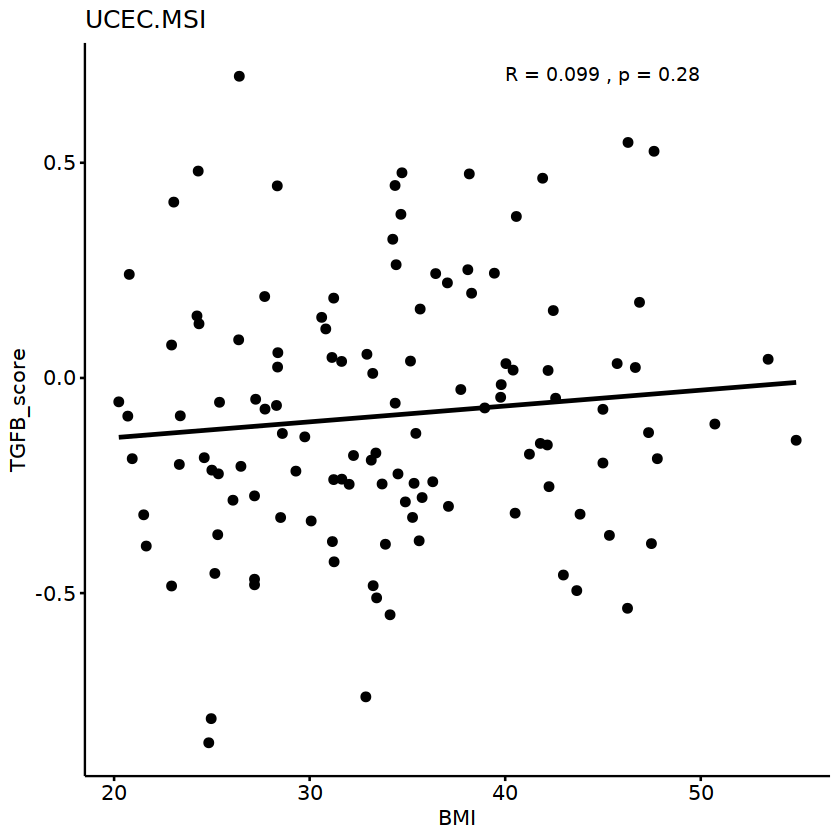

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


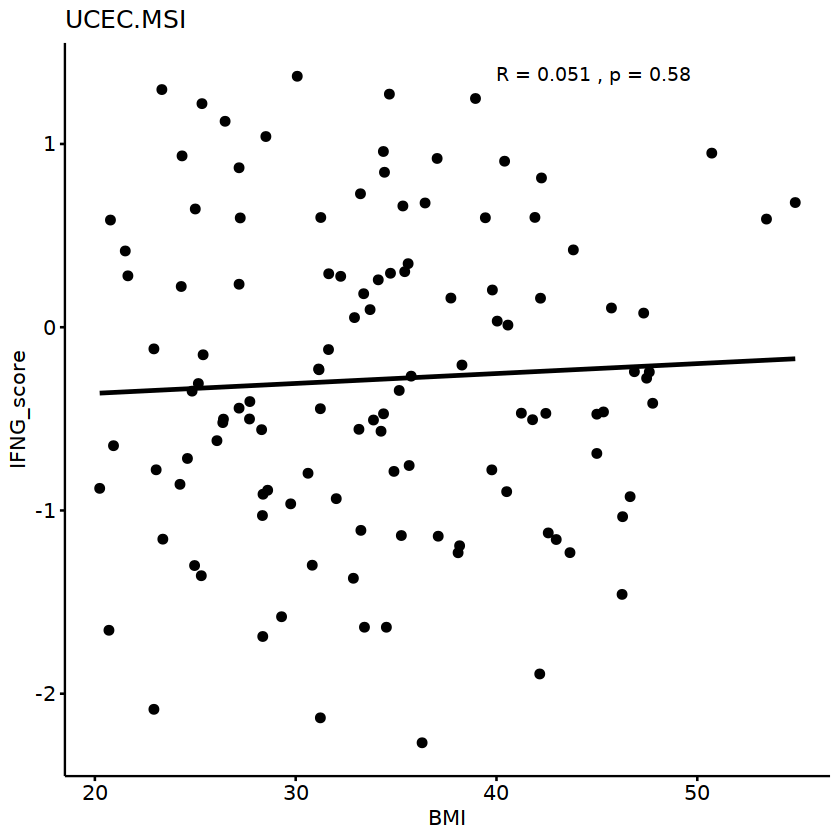

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


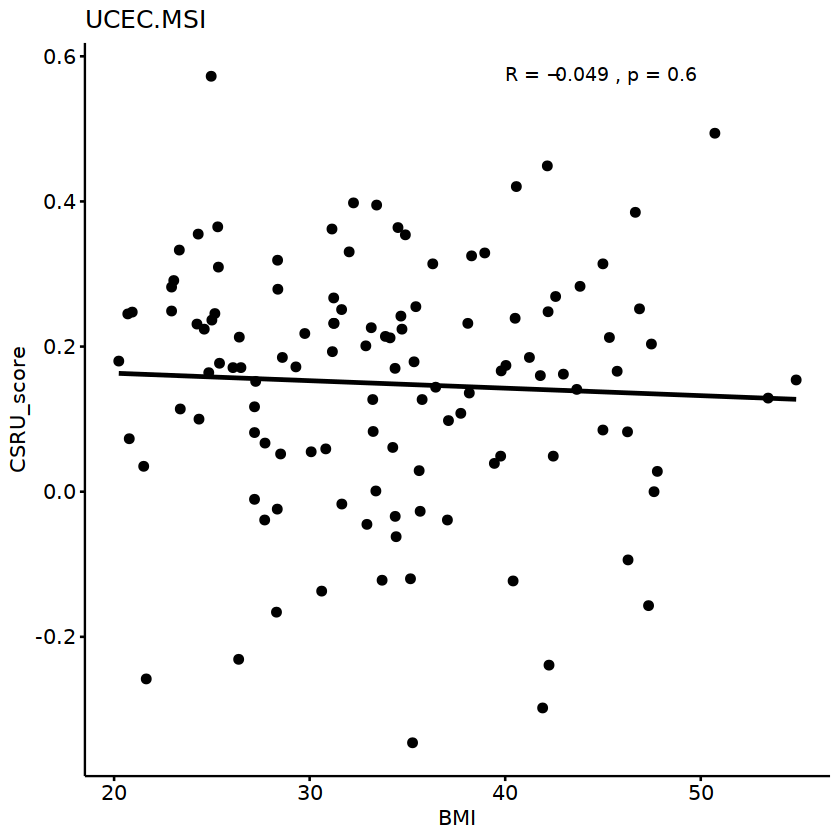

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


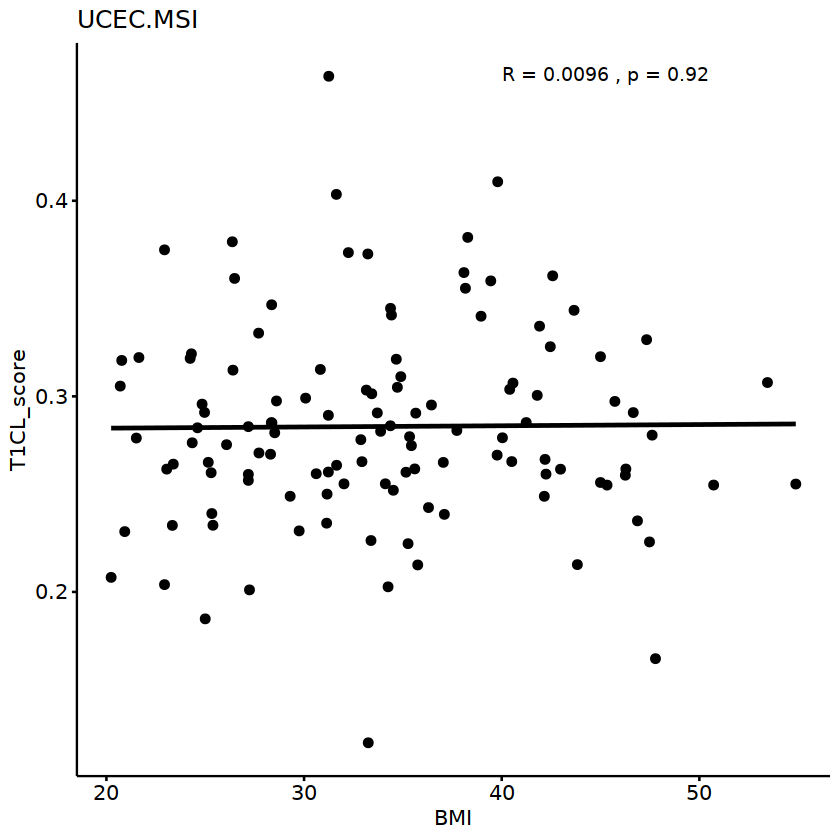

Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


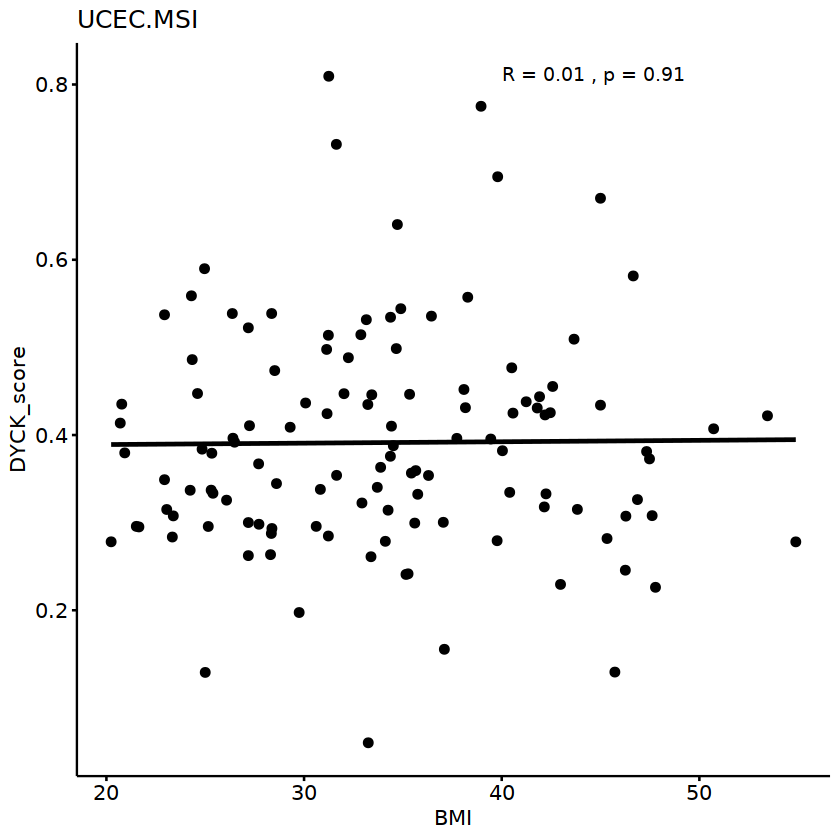

Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


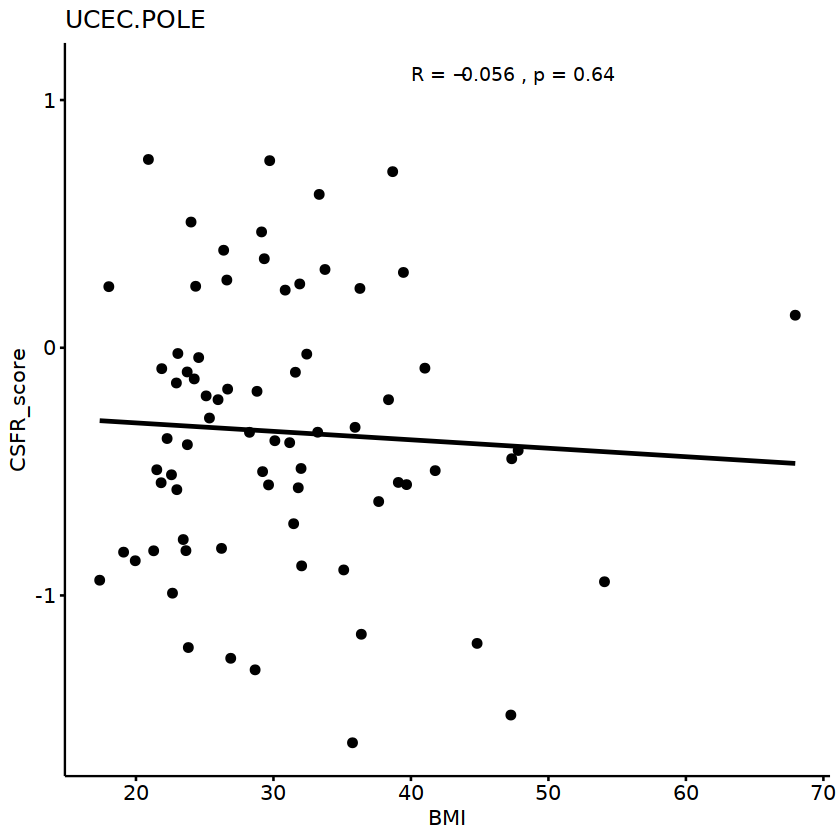

Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


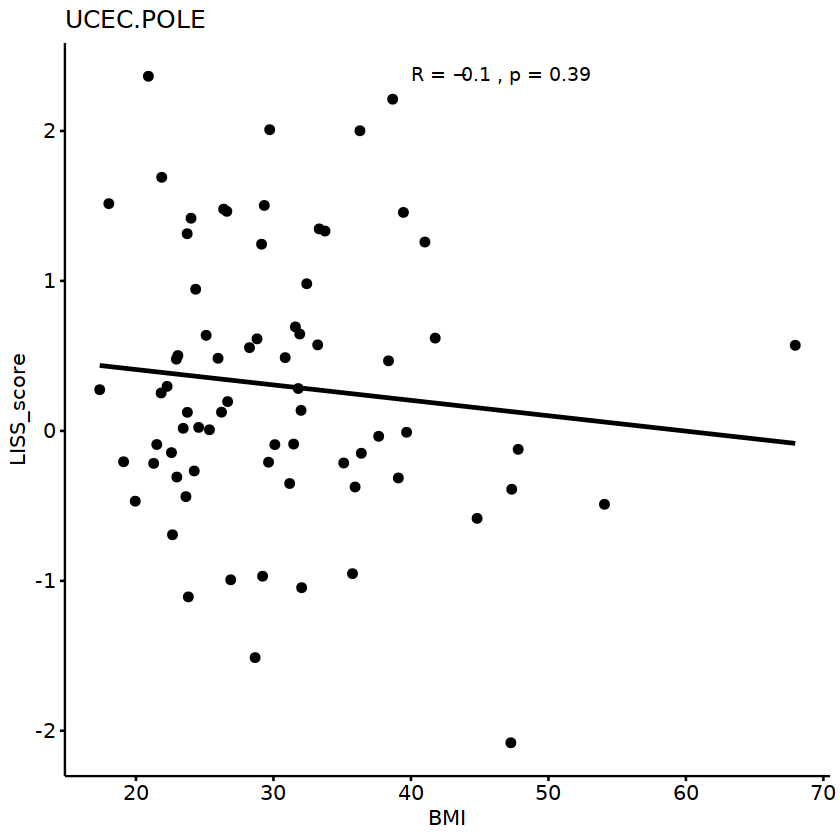

Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


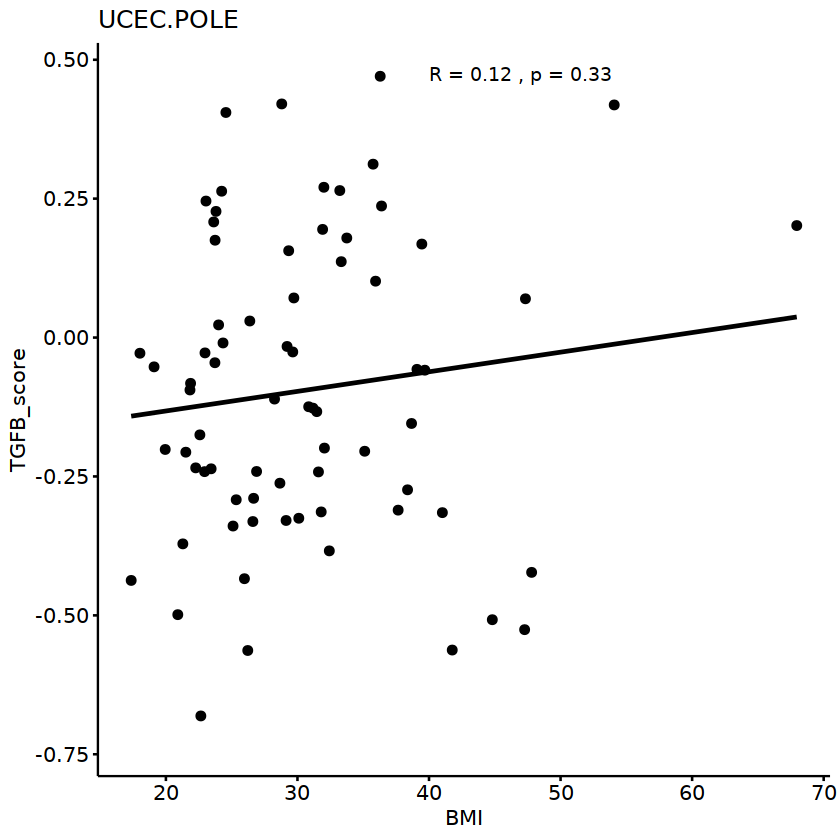

Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


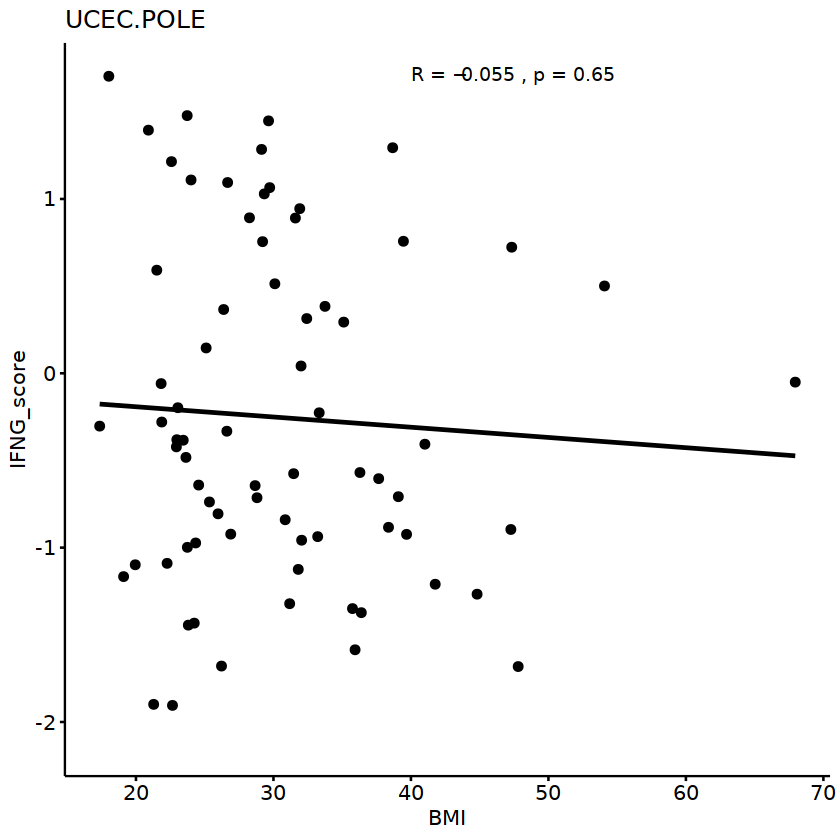

Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


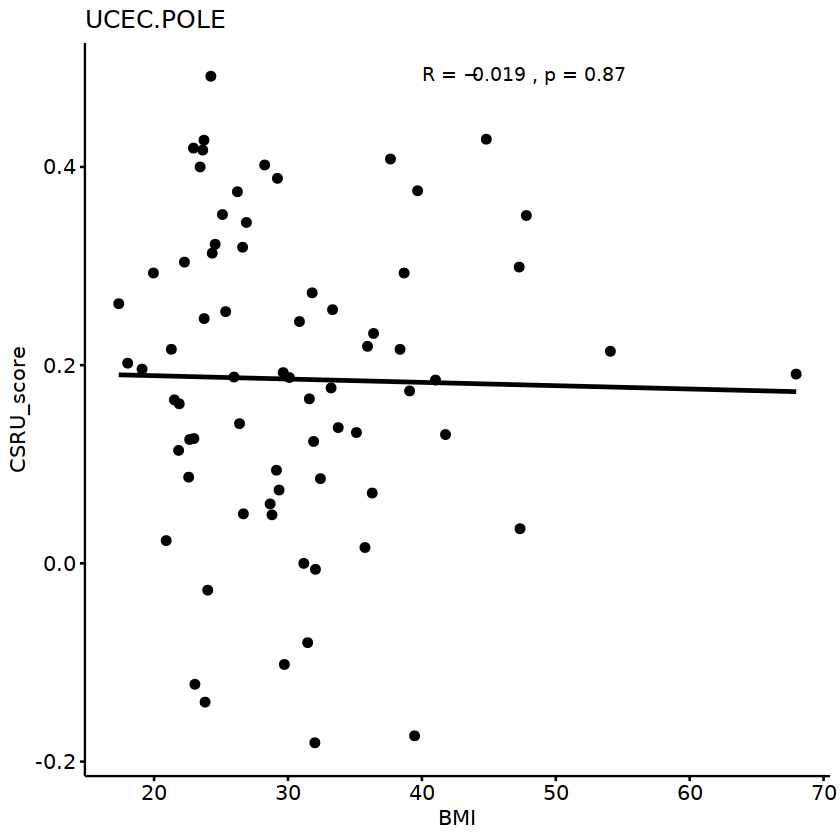

Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


[[1]]
[[1]][[1]]

[[1]][[2]]

[[1]][[3]]

[[1]][[4]]

[[1]][[5]]

[[1]][[6]]

[[1]][[7]]


[[2]]
[[2]][[1]]

[[2]][[2]]

[[2]][[3]]

[[2]][[4]]

[[2]][[5]]

[[2]][[6]]

[[2]][[7]]


[[3]]
[[3]][[1]]

[[3]][[2]]

[[3]][[3]]

[[3]][[4]]

[[3]][[5]]

[[3]][[6]]

[[3]][[7]]


[[4]]
[[4]][[1]]

[[4]][[2]]

[[4]][[3]]

[[4]][[4]]

[[4]][[5]]

[[4]][[6]]

[[4]][[7]]


[[5]]
[[5]][[1]]

[[5]][[2]]

[[5]][[3]]

[[5]][[4]]

[[5]][[5]]

[[5]][[6]]

[[5]][[7]]


[[6]]
[[6]][[1]]

[[6]][[2]]

[[6]][[3]]

[[6]][[4]]

[[6]][[5]]

[[6]][[6]]

[[6]][[7]]



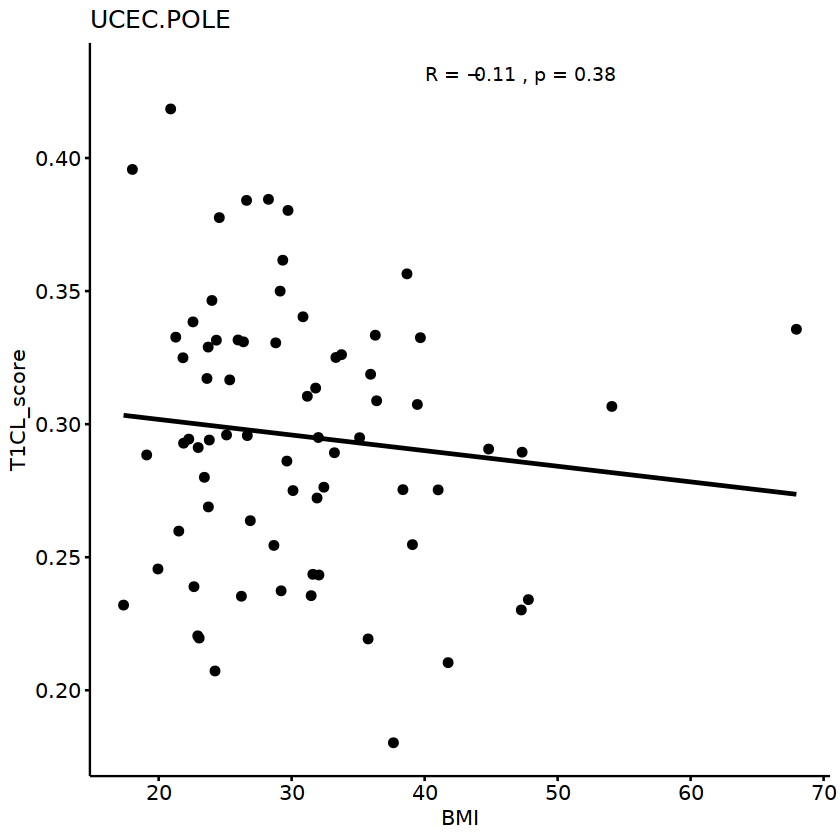

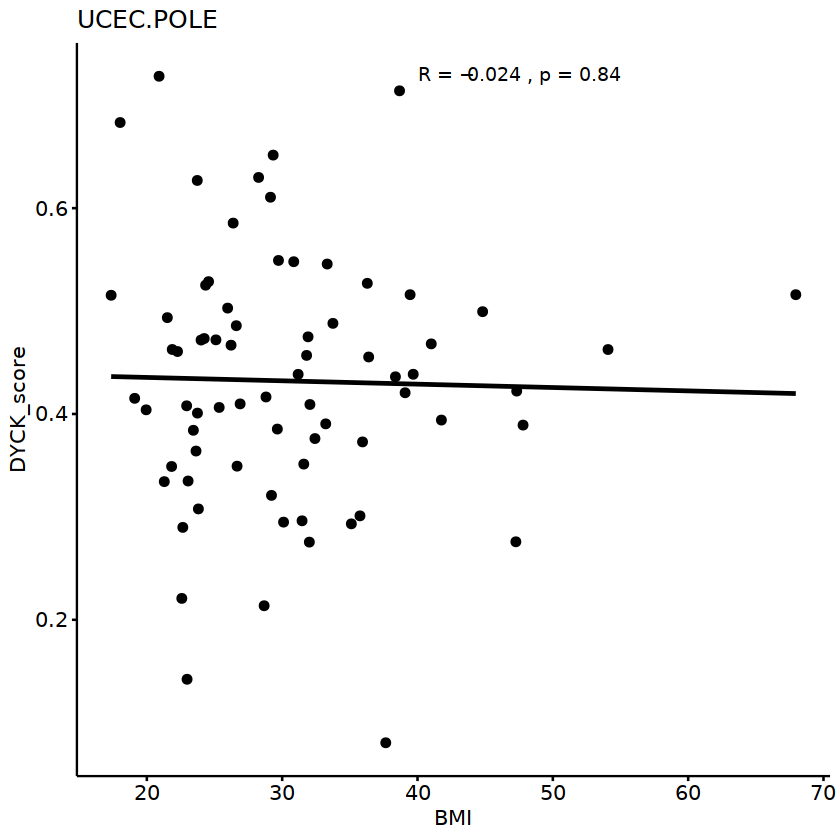

In [21]:
##per subtype, BMI vs. signature scores
SUBPLOTDIR <- paste0(PLOTDIR,"/subtype-sigs_vs_BMI/")
dir.create(SUBPLOTDIR, recursive=TRUE, showWarnings=FALSE)
sigs_metadata[["TCGA Subtype"]] <- factor(sigs_metadata[["TCGA Subtype"]], levels = c('NA', 'UCEC.', 'UCEC.CN_HIGH', 'UCEC.CN_LOW', 'UCEC.MSI', 'UCEC.POLE'))
lapply(levels(sigs_metadata[["TCGA Subtype"]]), function(f){
   subtype_metadata <- sigs_metadata %>% dplyr::filter(`TCGA Subtype` %in% f)
   lapply(names(sigList[[1]]), function(n){
        ggscatter(subtype_metadata, x = "BMI", y = n, add = "reg.line") +
           stat_cor(label.x = 40, label.y = max(subtype_metadata[,n])) +
           ggtitle(f)
        #ggsave(paste0(SUBPLOTDIR, "/subtype-", f, ".", n, ".vs_BMI.pdf"))
   })
})

In [22]:
##test score correlations
combn <- combinations(n=7, r=2, v=names(sigList[[1]]))
combnre <- gsub("score","rescore", combn)
ctl <- unlist(lapply(1:dim(combn)[1], function(f){
    comb <- combn[f,]
    ct <- suppressWarnings(cor.test(sigs_metadata[[comb[1]]], sigs_metadata[[comb[2]]], method = "spearman"))
    print(paste0("Testing: ", comb[1], " vs. ", comb[2], ": p = ", round(ct$p.value, digits=6)))
    return(ct$p.value)
}))


[1] "Testing: CSFR_score vs. CSRU_score: p = 0.001143"
[1] "Testing: CSFR_score vs. DYCK_score: p = 0"
[1] "Testing: CSFR_score vs. IFNG_score: p = 0"
[1] "Testing: CSFR_score vs. LISS_score: p = 0"
[1] "Testing: CSFR_score vs. T1CL_score: p = 0"
[1] "Testing: CSFR_score vs. TGFB_score: p = 0.000001"
[1] "Testing: CSRU_score vs. DYCK_score: p = 0.000236"
[1] "Testing: CSRU_score vs. IFNG_score: p = 0.021258"
[1] "Testing: CSRU_score vs. LISS_score: p = 0.037254"
[1] "Testing: CSRU_score vs. T1CL_score: p = 0.171422"
[1] "Testing: CSRU_score vs. TGFB_score: p = 0"
[1] "Testing: DYCK_score vs. IFNG_score: p = 0.007275"
[1] "Testing: DYCK_score vs. LISS_score: p = 0"
[1] "Testing: DYCK_score vs. T1CL_score: p = 0"
[1] "Testing: DYCK_score vs. TGFB_score: p = 0.025332"
[1] "Testing: IFNG_score vs. LISS_score: p = 0"
[1] "Testing: IFNG_score vs. T1CL_score: p = 0"
[1] "Testing: IFNG_score vs. TGFB_score: p = 0.943954"
[1] "Testing: LISS_score vs. T1CL_score: p = 0"
[1] "Testing: LISS_score 

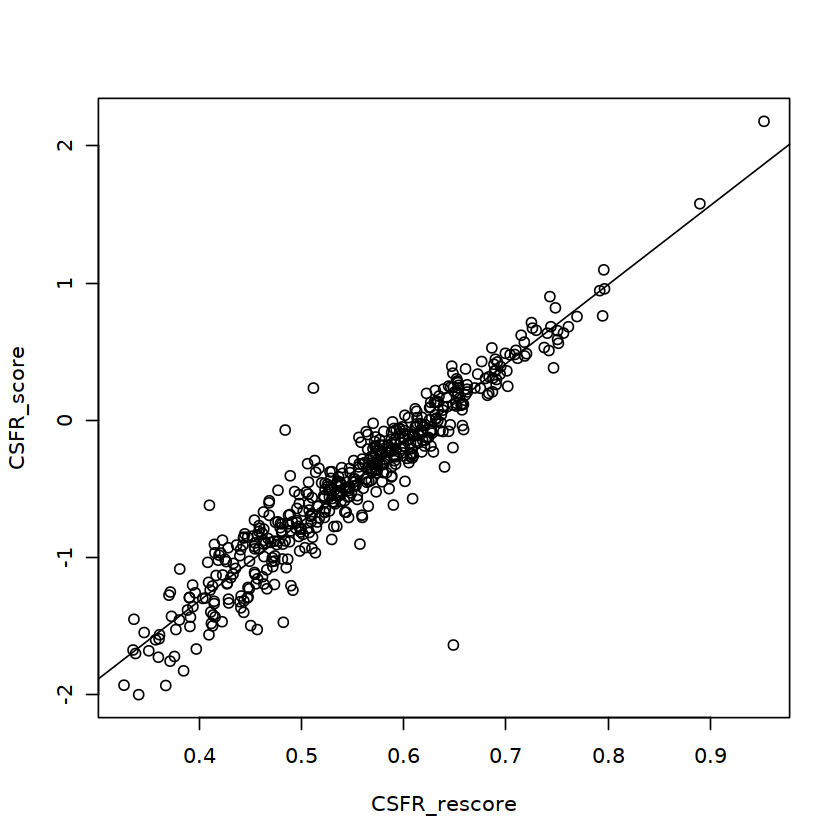

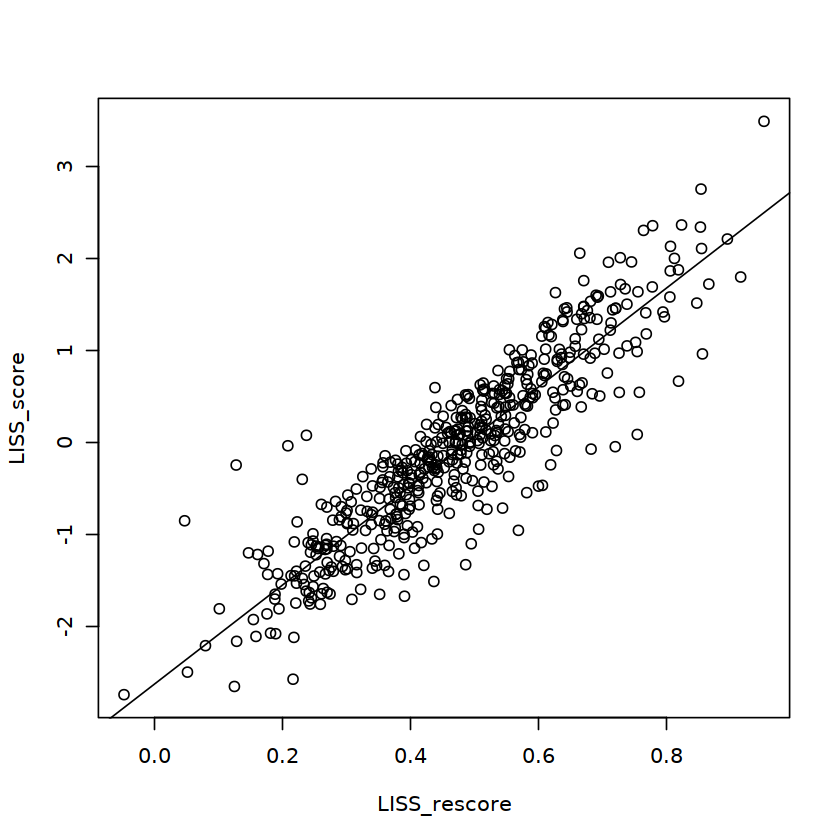

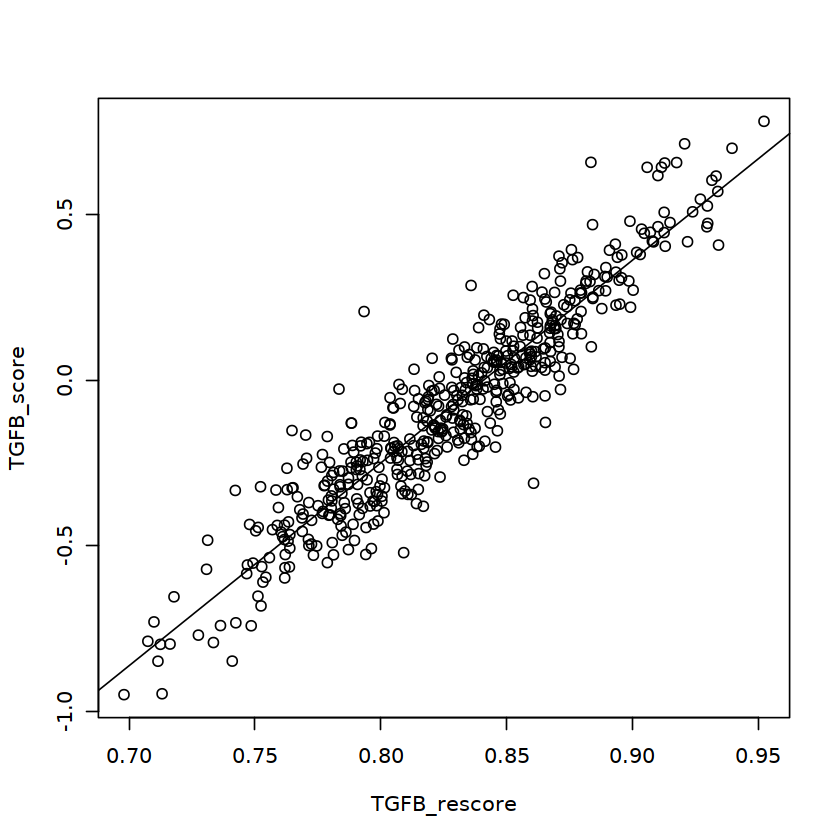

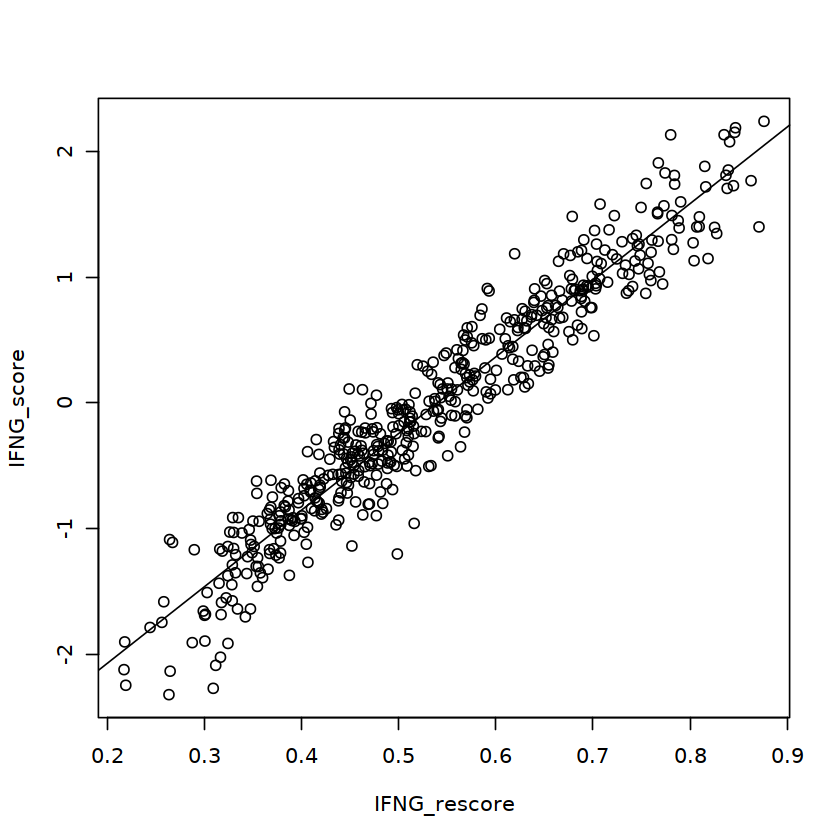

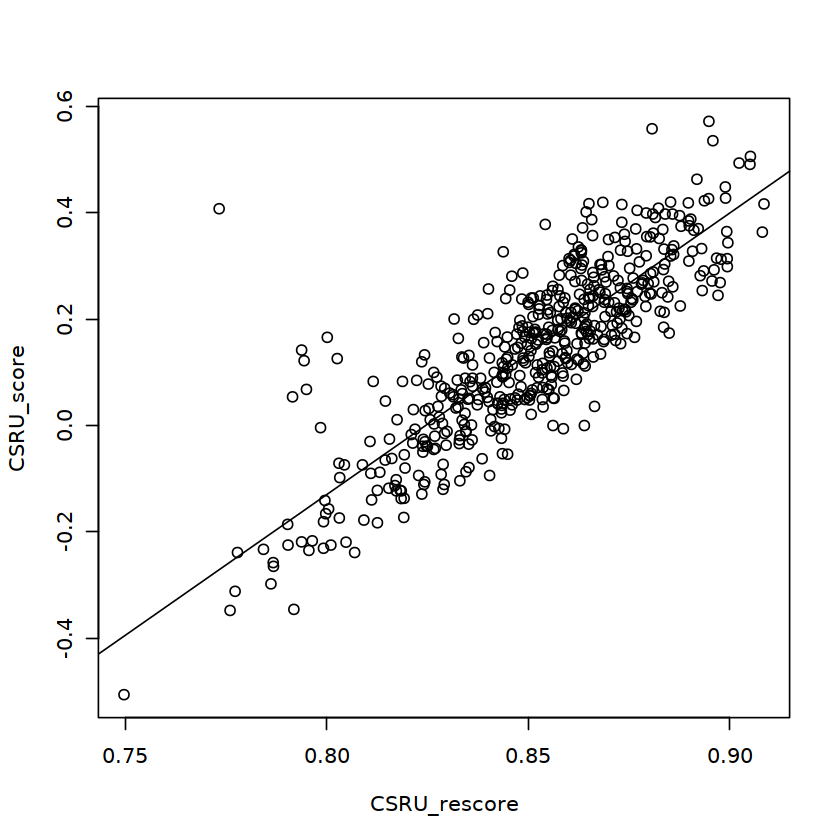

In [23]:
##test socre vs. rescore
combna <- unique(unlist(names(sigList[[1]])))
combnr <- gsub("score", "rescore", unique(unlist(names(sigList[[1]])))[1:5])
                 
for(i in 1:5){
        plot(sigs_metadata[[combnr[i]]], sigs_metadata[[combna[i]]], xlab=combnr[i], ylab=combna[i])
        abline(lm(sigs_metadata[[combna[i]]] ~ sigs_metadata[[combnr[i]]]))
}


In [24]:
##datasets for plotting and testing for each signature
##subset from all samples into endometrioid GR1,2, and all others
obs_norm_all_sigList <- NULL
obs_norm_all_sigList <- lapply(names(sigList[["ensembl_gene_id"]]), function(namef){
    sigf <- sigList[["ensembl_gene_id"]][[namef]]
    ff <- obs_norm_sigs %>% dplyr::select(ensembl_gene_id, external_gene_name, sample, histological_type, histological_grade, tpm, log2tpm, categorical_stage, BMI, BMI_cat, TMB_cat, CSFR_score, LISS_score, TGFB_score, IFNG_score, CSRU_score, T1CL_score, DYCK_score, CSFR_rescore, LISS_rescore, TGFB_rescore, IFNG_rescore, CSRU_rescore, 'TCGA Subtype') %>%
                            dplyr::filter(ensembl_gene_id %in% sigf)
    ff$BMI_cat <- factor(ff$BMI_cat, levels = c("lean", "int", "obese_1", "obese_2", NA))
    return(ff)
})
names(obs_norm_all_sigList) <- names(sigList[["ensembl_gene_id"]])
paste0("Samples in full cohort: ", length(unique(obs_norm_all_sigList[[1]]$sample)))

obs_norm_endomgr12_sigList <- lapply(obs_norm_all_sigList, function(f){
    ff <- f %>% dplyr::filter(histological_grade %in% c("G1", "G2"), histological_type %in% "Endometrioid endometrial adenocarcinoma")
    ff$BMI_cat <- factor(ff$BMI_cat, levels = c("lean", "int", "obese_1", "obese_2", NA))
    return(ff)
})

paste0("Samples in endometrioid, grades1, 2 cohort: ", length(unique(obs_norm_endomgr12_sigList[[1]]$sample)))

obs_norm_not_endomgr12_sigList <- lapply(seq_along(obs_norm_all_sigList), function(f){
    ff <- obs_norm_all_sigList[[f]] %>% dplyr::filter(!sample %in% unique(obs_norm_endomgr12_sigList[[f]]$sample))
    ff$BMI_cat <- factor(ff$BMI_cat, levels = c("lean", "int", "obese_1", "obese_2", NA))
    return(ff)
})
paste0("Samples NOT in endometrioid, grades1, 2 cohort: ", length(unique(obs_norm_not_endomgr12_sigList[[1]]$sample)))

[1] "Samples in full cohort: 513"

[1] "Samples in endometrioid, grades1, 2 cohort: 211"

[1] "Samples NOT in endometrioid, grades1, 2 cohort: 302"

In [28]:
##datasets for plotting and testing for each signature
##split into all samples, endometrioid GR1,2, and all not in second
##here only fror lean, obese
obs_norm_all_sigList_ln_ob <- NULL
obs_norm_all_sigList_ln_ob <- lapply(names(sigList[["ensembl_gene_id"]]), function(namef){
    sigf <- sigList[["ensembl_gene_id"]][[namef]]
    ff <- obs_norm_sigs %>% dplyr::select(ensembl_gene_id, external_gene_name, sample, histological_type, histological_grade, tpm, log2tpm, categorical_stage, BMI_cat, TMB_cat, CSFR_score, LISS_score, TGFB_score, IFNG_score, CSRU_score, T1CL_score, DYCK_score, CSFR_rescore, LISS_rescore, TGFB_rescore, IFNG_rescore, CSRU_rescore,'TCGA Subtype') %>%
                            dplyr::filter(ensembl_gene_id %in% sigf) %>%
                            dplyr::filter(BMI_cat %in% c("lean", "obese_1", "obese_2"))
    ff$BMI_cat <- factor(ff$BMI_cat, levels = c("lean", "obese_1", "obese_2"))
    return(ff)
})
names(obs_norm_all_sigList_ln_ob) <- names(sigList[["ensembl_gene_id"]])
paste0("Samples in full cohort: ", length(unique(obs_norm_all_sigList_ln_ob[[1]]$sample)))

obs_norm_endomgr12_sigList_ln_ob <- lapply(obs_norm_all_sigList_ln_ob, function(f){
    ff <- f %>% dplyr::filter(histological_grade %in% c("G1", "G2"), histological_type %in% "Endometrioid endometrial adenocarcinoma")
    ff$BMI_cat <- factor(ff$BMI_cat, levels = c("lean", "obese_1", "obese_2"))
    return(ff)
})

paste0("Samples in endometrioid, grades1, 2 cohort: ", length(unique(obs_norm_endomgr12_sigList_ln_ob[[1]]$sample)))

obs_norm_not_endomgr12_sigList_ln_ob <- lapply(seq_along(obs_norm_all_sigList_ln_ob), function(f){
    ff <- obs_norm_all_sigList_ln_ob[[f]] %>% dplyr::filter(!sample %in% unique(obs_norm_endomgr12_sigList_ln_ob[[f]]$sample))
    ff$BMI_cat <- factor(ff$BMI_cat, levels = c("lean", "obese_1", "obese_2"))
    return(ff)
})
paste0("Samples NOT in endometrioid, grades1, 2 cohort: ", length(unique(obs_norm_not_endomgr12_sigList_ln_ob[[1]]$sample)))

[1] "Samples in full cohort: 377"

[1] "Samples in endometrioid, grades1, 2 cohort: 162"

[1] "Samples NOT in endometrioid, grades1, 2 cohort: 215"

In [29]:
# ##subtypes
#'UCEC.CN_HIGH' 'UCEC.CN_LOW' 'UCEC.POLE' 'UCEC.' 'UCEC.MSI' 'NA' 
subtypes <- c("UCEC.POLE", "UCEC.MSI", "UCEC.CN_HIGH", "UCEC.CN_LOW")

subtypeList <- lapply(subtypes, function(f){
    onas <- lapply(names(obs_norm_all_sigList), function(ff){
        obs_norm_all_sigList[[ff]] %>% dplyr::filter(`TCGA Subtype` %in% f)
    })
    names(onas) <- names(obs_norm_all_sigList)
    onas
})

names(subtypeList) <- subtypes

subtypeList_ln_ob <- lapply(subtypes, function(f){
    onas <- lapply(names(obs_norm_all_sigList_ln_ob), function(ff){
        obs_norm_all_sigList_ln_ob[[ff]] %>% dplyr::filter(`TCGA Subtype` %in% f)
    })
    names(onas) <- names(obs_norm_all_sigList_ln_ob)
    onas
})

names(subtypeList_ln_ob) <- subtypes

Joining, by = "sample"
Warning message:
“Column `sample` joining character vector and factor, coercing into character vector”
Warning message:
“Ignoring unknown parameters: method”
Warning message:
“Removed 238 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 238 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 238 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 238 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


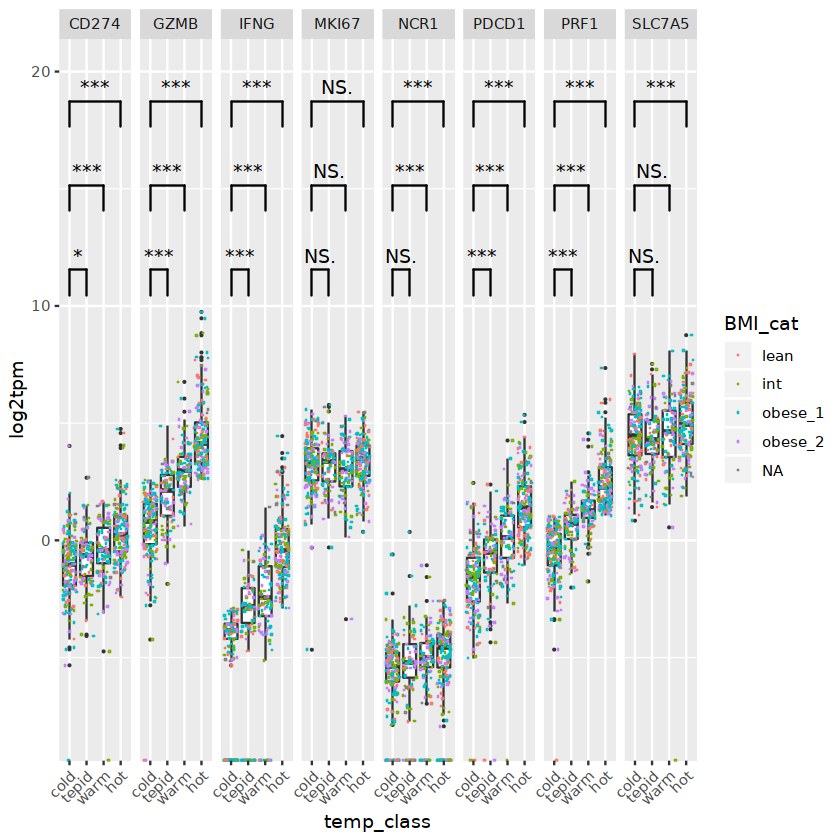

In [30]:
#IFNg, GZMB and PRF1 subclasses
#strategy: take quartile of exp per gene, sum to give [4x3] max score for exp, then rank samples
obs_norm_geneset <- obs_norm_all_sigList[["DYCK_score"]]
obs_norm_geneset_sc <- as_tibble(do.call(cbind,lapply(c("IFNG", "GZMB", "PRF1"), function(f){
    medScore <- obs_norm_geneset %>% 
                dplyr::filter(external_gene_name %in% f) %>% 
                dplyr::select(log2tpm) %>% 
                unlist() %>% median()
    colin <- obs_norm_geneset %>% 
             dplyr::filter(external_gene_name %in% f) %>% 
             dplyr::select(log2tpm) %>% as.data.frame()
    colout <- rep(0, times=dim(colin)[1])
    colout[colin > medScore] <- 1
    names(colout)<-f
    return(colout)
})))
obs_norm_geneset_sc$SC_sum <- rowSums(obs_norm_geneset_sc)
colnames(obs_norm_geneset_sc) <- c("IFNG", "GZMB", "PRF1", "SC_sum")
obs_norm_geneset_sc <- left_join(obs_norm_geneset, as_tibble(cbind(obs_norm_geneset$sample, obs_norm_geneset_sc)) %>% dplyr::rename(sample = 1)) %>% unique()

##create temp_Class
obs_norm_geneset_sc$SC_sum <- factor(obs_norm_geneset_sc$SC_sum, levels = c(0,1,2,3))
obs_norm_geneset_sc$temp_class <- revalue(obs_norm_geneset_sc$SC_sum, c("0"="cold", "1"="tepid", "2"="warm", "3"="hot"))

gssSC <- obs_norm_geneset_sc %>% dplyr::select(external_gene_name, sample, log2tpm, BMI_cat, SC_sum)

gssSC$SC_sum <- factor(gssSC$SC_sum, levels = c(0,1,2,3))
gssSC$temp_class <- revalue(gssSC$SC_sum, c("0"="cold", "1"="tepid", "2"="warm", "3"="hot"))

ggplot(gssSC, aes(x=temp_class, y=log2tpm)) + 
geom_boxplot(outlier.size = 0.1) +
geom_jitter(data=gssSC, aes(x=temp_class, y=log2tpm, colour=BMI_cat), cex=0.1, pch=0)  +
lims(y=c(-8, 20)) +
geom_signif(comparisons = list(c("cold","tepid"),c("cold","warm"), c("cold","hot")), map_signif_level=TRUE, method="wilcox", step_increase=0.1) +
facet_grid(~external_gene_name) +
theme(axis.text.x = element_text(angle=45, hjust=1))
ggsave(paste0(PLOTDIR,"/temp_class-vs-log2tpm.pdf"))


In [31]:
##ANOVA for signature scores
##testing BMI_cat, TMB_cat ~ scores, in all and subtypes

aov_cat_func <- function(listin, cate){
    lapply(names(listin), function(ff){      
    aov_inp <- listin[[ff]] %>% dplyr::select(-1,-2,-tpm,-log2tpm) %>% distinct()
    aov_f <- aov(get(ff) ~ get(cate), data=aov_inp)
    return(summary(aov_f))
})}

obs_norm_all_aov_BMI <- aov_cat_func(obs_norm_all_sigList, "BMI_cat")
names(obs_norm_all_aov_BMI) <- names(obs_norm_all_sigList)

obs_norm_endomgr12_aov_BMI <- aov_cat_func(obs_norm_endomgr12_sigList, "BMI_cat")
names(obs_norm_endomgr12_aov_BMI) <- names(obs_norm_endomgr12_sigList)

obs_norm_all_aov_ln_ob_BMI <- aov_cat_func(obs_norm_all_sigList_ln_ob, "BMI_cat")
names(obs_norm_all_aov_ln_ob_BMI) <- names(obs_norm_all_sigList_ln_ob)

subtypeList_aov_BMI <- lapply(names(subtypeList), function(f){     
    sumaov <- aov_cat_func(subtypeList[[f]], "BMI_cat")
    names(sumaov) <- names(subtypeList[[f]])
    sumaov
})
names(subtypeList_aov_BMI) <- names(subtypeList)

########TMB
obs_norm_all_aov_TMB <- aov_cat_func(obs_norm_all_sigList, "TMB_cat")
names(obs_norm_all_aov_TMB) <- names(obs_norm_all_aov_BMI)

obs_norm_endomgr12_aov_TMB <- aov_cat_func(obs_norm_endomgr12_sigList, "TMB_cat")
names(obs_norm_endomgr12_aov_TMB) <- names(obs_norm_endomgr12_sigList)

obs_norm_all_aov_ln_ob_TMB <- aov_cat_func(obs_norm_all_sigList_ln_ob, "TMB_cat")
names(obs_norm_all_aov_ln_ob_TMB) <- names(obs_norm_all_sigList_ln_ob)

subtypeList_aov_TMB <- lapply(names(subtypeList), function(f){     
    sumaov <- aov_cat_func(subtypeList[[f]], "TMB_cat")
    names(sumaov) <- names(subtypeList[[f]])
    sumaov
})
names(subtypeList_aov_TMB) <- names(subtypeList)


In [32]:
print("########################")
print("########################")
print("All Patients, BMI")
obs_norm_all_aov_BMI
print("########################")
print("########################")
print("Endometrioid Patients, BMI")
obs_norm_endomgr12_aov_BMI
print("########################")
print("########################")
print("Lean/Obese Patients, BMI")
obs_norm_all_aov_ln_ob_BMI
print("########################")
print("########################")
print("Subtypes, BMI")
subtypeList_aov_BMI


print("########################")
print("########################")
print("All Patients, TMB")
obs_norm_all_aov_TMB
print("########################")
print("########################")
print("Endometrioid Patients, TMB")
obs_norm_endomgr12_aov_TMB
print("########################")
print("########################")
print("Lean/Obese Patients, TMB")
obs_norm_all_aov_ln_ob_TMB
print("########################")
print("########################")
print("Subtypes, TMB")
subtypeList_aov_TMB


[1] "########################"
[1] "########################"
[1] "All Patients, BMI"


$CSFR_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     3   0.86  0.2870   0.815  0.486
Residuals   480 169.03  0.3521               
29 observations deleted due to missingness

$LISS_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     3    2.5  0.8231   0.838  0.473
Residuals   480  471.3  0.9818               
29 observations deleted due to missingness

$TGFB_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     3   0.23 0.07588   0.828  0.479
Residuals   480  44.01 0.09168               
29 observations deleted due to missingness

$IFNG_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     3    1.2  0.4037   0.474  0.701
Residuals   480  409.0  0.8522               
29 observations deleted due to missingness

$CSRU_score
             Df Sum Sq Mean Sq F value Pr(>F)  
get(cate)     3  0.252 0.08387   3.165 0.0243 *
Residuals   480 12.720 0.02650                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
2

[1] "########################"
[1] "########################"
[1] "Endometrioid Patients, BMI"


$CSFR_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     3   1.01  0.3371   1.173  0.321
Residuals   202  58.04  0.2873               
5 observations deleted due to missingness

$LISS_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     3   2.49  0.8289   1.026  0.382
Residuals   202 163.24  0.8081               
5 observations deleted due to missingness

$TGFB_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     3   0.46 0.15323   1.895  0.132
Residuals   202  16.33 0.08086               
5 observations deleted due to missingness

$IFNG_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     3   1.31  0.4370   0.675  0.568
Residuals   202 130.71  0.6471               
5 observations deleted due to missingness

$CSRU_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     3  0.121 0.04032   1.564  0.199
Residuals   202  5.206 0.02577               
5 observations deleted due to missingness

$T1CL_score
             Df Sum Sq 

[1] "########################"
[1] "########################"
[1] "Lean/Obese Patients, BMI"


$CSFR_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2    0.2  0.1010   0.289  0.749
Residuals   374  130.7  0.3495               

$LISS_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2    0.7  0.3453   0.358  0.699
Residuals   374  360.4  0.9637               

$TGFB_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2   0.07 0.03308   0.358  0.699
Residuals   374  34.53 0.09232               

$IFNG_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2   1.16  0.5820   0.689  0.503
Residuals   374 315.84  0.8445               

$CSRU_score
             Df Sum Sq Mean Sq F value Pr(>F)  
get(cate)     2  0.238 0.11891    4.36 0.0134 *
Residuals   374 10.200 0.02727                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$T1CL_score
             Df Sum Sq  Mean Sq F value Pr(>F)
get(cate)     2 0.0083 0.004173   1.736  0.178
Residuals   374 0.8988 0.002403               

$DYCK_score
      

[1] "########################"
[1] "########################"
[1] "Subtypes, BMI"


$UCEC.POLE
$UCEC.POLE$CSFR_score
            Df Sum Sq Mean Sq F value Pr(>F)
get(cate)    3  0.906  0.3019   1.007  0.395
Residuals   68 20.380  0.2997               
7 observations deleted due to missingness

$UCEC.POLE$LISS_score
            Df Sum Sq Mean Sq F value Pr(>F)
get(cate)    3   1.98  0.6597   0.816  0.489
Residuals   68  54.97  0.8085               
7 observations deleted due to missingness

$UCEC.POLE$TGFB_score
            Df Sum Sq Mean Sq F value Pr(>F)
get(cate)    3  0.288 0.09590   1.326  0.273
Residuals   68  4.919 0.07234               
7 observations deleted due to missingness

$UCEC.POLE$IFNG_score
            Df Sum Sq Mean Sq F value Pr(>F)
get(cate)    3   3.48  1.1584    1.27  0.292
Residuals   68  62.05  0.9125               
7 observations deleted due to missingness

$UCEC.POLE$CSRU_score
            Df Sum Sq Mean Sq F value Pr(>F)
get(cate)    3 0.0826 0.02754    1.13  0.343
Residuals   68 1.6575 0.02438               
7 observations deleted due to mi

[1] "########################"
[1] "########################"
[1] "All Patients, TMB"


$CSFR_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2   1.15  0.5767   1.637  0.196
Residuals   510 179.72  0.3524               

$LISS_score
             Df Sum Sq Mean Sq F value    Pr(>F)    
get(cate)     2   20.4  10.223   10.72 0.0000275 ***
Residuals   510  486.3   0.953                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$TGFB_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2   0.14 0.07087   0.769  0.464
Residuals   510  46.98 0.09211               

$IFNG_score
             Df Sum Sq Mean Sq F value   Pr(>F)    
get(cate)     2   12.6   6.314    7.64 0.000538 ***
Residuals   510  421.5   0.827                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$CSRU_score
             Df Sum Sq Mean Sq F value  Pr(>F)   
get(cate)     2  0.274 0.13708   5.178 0.00594 **
Residuals   510 13.502 0.02647                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

[1] "########################"
[1] "########################"
[1] "Endometrioid Patients, TMB"


$CSFR_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2   0.06 0.03206   0.111  0.895
Residuals   208  59.90 0.28798               

$LISS_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2    2.8  1.4007    1.75  0.176
Residuals   208  166.5  0.8005               

$TGFB_score
             Df Sum Sq Mean Sq F value Pr(>F)  
get(cate)     2  0.408 0.20384   2.543  0.081 .
Residuals   208 16.670 0.08014                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$IFNG_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2   0.87  0.4328   0.662  0.517
Residuals   208 135.98  0.6537               

$CSRU_score
             Df Sum Sq Mean Sq F value Pr(>F)  
get(cate)     2  0.228 0.11403   4.607  0.011 *
Residuals   208  5.148 0.02475                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$T1CL_score
             Df Sum Sq  Mean Sq F value Pr(>F)  
get(cate)     2 0.0136 0.006786   3.13

[1] "########################"
[1] "########################"
[1] "Lean/Obese Patients, TMB"


$CSFR_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2   0.11  0.0554   0.158  0.854
Residuals   374 130.80  0.3497               

$LISS_score
             Df Sum Sq Mean Sq F value Pr(>F)  
get(cate)     2    7.5   3.735    3.95 0.0201 *
Residuals   374  353.7   0.946                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$TGFB_score
             Df Sum Sq Mean Sq F value Pr(>F)
get(cate)     2   0.17 0.08464    0.92    0.4
Residuals   374  34.42 0.09204               

$IFNG_score
             Df Sum Sq Mean Sq F value    Pr(>F)    
get(cate)     2  17.65   8.827   11.03 0.0000222 ***
Residuals   374 299.35   0.800                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$CSRU_score
             Df Sum Sq Mean Sq F value Pr(>F)   
get(cate)     2  0.261 0.13043   4.793 0.0088 **
Residuals   374 10.177 0.02721                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$T1CL_sc

[1] "########################"
[1] "########################"
[1] "Subtypes, TMB"


$UCEC.POLE
$UCEC.POLE$CSFR_score
            Df Sum Sq Mean Sq F value Pr(>F)
get(cate)    2  0.824  0.4120   1.227  0.299
Residuals   76 25.523  0.3358               

$UCEC.POLE$LISS_score
            Df Sum Sq Mean Sq F value Pr(>F)
get(cate)    2   2.09  1.0443   1.225  0.299
Residuals   76  64.77  0.8522               

$UCEC.POLE$TGFB_score
            Df Sum Sq Mean Sq F value Pr(>F)
get(cate)    2  0.131 0.06531   0.838  0.436
Residuals   76  5.919 0.07789               

$UCEC.POLE$IFNG_score
            Df Sum Sq Mean Sq F value Pr(>F)
get(cate)    2   0.75  0.3757   0.381  0.684
Residuals   76  74.91  0.9857               

$UCEC.POLE$CSRU_score
            Df Sum Sq Mean Sq F value Pr(>F)  
get(cate)    2 0.1989 0.09943   4.489 0.0144 *
Residuals   76 1.6832 0.02215                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$UCEC.POLE$T1CL_score
            Df  Sum Sq  Mean Sq F value Pr(>F)
get(cate)    2 0.00309 0.001543    0.56  0.574
Residuals 

In [33]:
##aim is to determine which genes of signatures are significant 
##in both obesity groups, and each obesity group individually
##groups here are BMI categories lean, obese_1, obese_2 only
##apply an FDR adjustment as multiple tests involved

##function to find wilcox p-value in col 'group', between levels 'group1' and 'group2'
##using expression 'value' as at gene level (log2tpm as it is continuous)
wilcox_sig_groups <- function(long_data, ext_genes, group, group1, group2, value){
    unlist(lapply(ext_genes, function(f){
        gr1 <- long_data %>% 
                dplyr::filter(get(!!group) %in% group1, external_gene_name %in% f) %>% 
                dplyr::select(!!value) %>% unlist()
        gr2 <- long_data %>% 
                dplyr::filter(get(!!group) %in% group2, external_gene_name %in% f) %>% 
                dplyr::select(!!value) %>% unlist()
        ##require 5+ samples 
        if(length(unique(gr1)) >= 6){
             if(length(unique(gr2)) >= 6){
             wt <- wilcox.test(gr1, gr2)
             return(wt$p.value)
         }}
         else{return(1)}
}))}

##test the results of groups being tested above, find
ws_both_first_last <- function(f, groupvec){
    ws_both <- as_tibble(t(bind_rows(f[[1]], f[[2]])), rownames="gene") %>% 
                dplyr::filter(V1 < 0.05 & V2 < 0.05) %>% arrange(gene)
    ws_first <- as_tibble(t(bind_rows(f[[1]], f[[2]])), rownames="gene") %>% 
                dplyr::filter(V1 < 0.05 & V2 > 0.05) %>% arrange(gene) 
    ws_last <- as_tibble(t(bind_rows(f[[1]], f[[2]])), rownames="gene") %>% 
                dplyr::filter(V1 > 0.05 & V2 < 0.05) %>% arrange(gene)
    colnames(ws_both) <- colnames(ws_first) <- colnames(ws_last) <- c("gene", groupvec[[2]], groupvec[[3]])
    ws_bfl <- list(ws_both, ws_first, ws_last)
    names(ws_bfl) <- c(paste0(groupvec[1], " - ", groupvec[2], " and ", groupvec[3]),
                       paste0(groupvec[1], " - ", groupvec[2], " not ", groupvec[3]),
                       paste0(groupvec[1], " - ", groupvec[3], " not ", groupvec[2]))
    return(ws_bfl)
}


In [34]:
##test group BMI_cat, groups obese_1, obese_2 both vs. lean
##return results that are 3xn table: gene, obese_1 vs. lean pval, obese_2 vs. lean pval (@5% FDR)
wilcox_obs_norm_all_sigList <- as.list(names(obs_norm_all_sigList))
wilcox_obs_norm_all_sigList <- lapply(names(obs_norm_all_sigList), function(f){
    ws1 <- lapply(list(c("BMI_cat", "lean", "obese_1"),
                       c("BMI_cat", "lean", "obese_2")), function(ff){
        ws0 <- wilcox_sig_groups(obs_norm_all_sigList[[f]], 
                          ext_genes=unlist(unique(obs_norm_all_sigList[[f]]$external_gene_name)),
                          group=ff[1], group1=ff[2], group2=ff[3], value="log2tpm")
        names(ws0) <- unlist(unique(obs_norm_all_sigList[[f]]$external_gene_name))
        #p.adjust(ws0,"BH")
        ws0
    })
    ws_both_first_last(ws1, c("BMI category", "obese_1", "obese_2"))
})   
names(wilcox_obs_norm_all_sigList) <- gsub("_score", "", names(obs_norm_all_sigList))


In [35]:
##test group BMI_cat, groups obese_1, obese_2 both vs. lean
##return results that are 3xn table: gene, obese_1 vs. lean pval, obese_2 vs. lean pval (@5% FDR)
wilcox_obs_norm_all_sigList_BH <- as.list(names(obs_norm_all_sigList))
wilcox_obs_norm_all_sigList_BH <- lapply(names(obs_norm_all_sigList), function(f){
    ws1 <- lapply(list(c("BMI_cat", "lean", "obese_1"),
                       c("BMI_cat", "lean", "obese_2")), function(ff){
        ws0 <- wilcox_sig_groups(obs_norm_all_sigList[[f]], 
                          ext_genes=unlist(unique(obs_norm_all_sigList[[f]]$external_gene_name)),
                          group=ff[1], group1=ff[2], group2=ff[3], value="log2tpm")
        names(ws0) <- unlist(unique(obs_norm_all_sigList[[f]]$external_gene_name))
        p.adjust(ws0,"BH")
    })
    ws_both_first_last(ws1, c("BMI category", "obese_1", "obese_2"))
})   
names(wilcox_obs_norm_all_sigList_BH) <- gsub("_score", "", names(obs_norm_all_sigList))

In [36]:
wilcox_obs_norm_all_sigList_BH

$CSFR
$CSFR$`BMI category - obese_1 and obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$CSFR$`BMI category - obese_1 not obese_2`
# A tibble: 1 x 3
  gene   obese_1 obese_2
  <chr>    <dbl>   <dbl>
1 SAMHD1  0.0196   0.256

$CSFR$`BMI category - obese_2 not obese_1`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>


$LISS
$LISS$`BMI category - obese_1 and obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$LISS$`BMI category - obese_1 not obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$LISS$`BMI category - obese_2 not obese_1`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>


$TGFB
$TGFB$`BMI category - obese_1 and obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$TGFB$`BMI category - obese_1 not obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$TGFB$`BMI category - obese_2 not obese_1`
# A tibble: 1 x 3
  gene   obese_1 obese_2
  <chr>    <dbl>   <dbl>
1 IGFBP4   0.458 0.00806


$IFNG
$IFNG$`BMI category - obese_1 and obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$IFNG$`BMI category - obese_1 not obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$IFNG$`BMI category - obese_2 not obese_1`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>


$CSRU
$CSRU$`BMI category - obese_1 and obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$CSRU$`BMI category - obese_1 not obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$CSRU$`BMI category - obese_2 not obese_1`
# A tibble: 13 x 3
   gene   obese_1 obese_2
   <chr>    <dbl>   <dbl>
 1 CENPN   0.0969  0.0195
 2 FARSA   0.380   0.0452
 3 GNG11   0.526   0.0452
 4 ID3     0.614   0.0251
 5 MT3     0.0736  0.0195
 6 MYBL2   0.543   0.0195
 7 NRIP3   0.107   0.0106
 8 PSMD12  0.0736  0.0240
 9 SKA1    0.110   0.0194
10 SKA2    0.0736  0.0224
11 SNRPB   0.616   0.0341
12 TUBA4A  0.154   0.0224
13 WDR77   0.0942  0.0106


$T1CL
$T1CL$`BMI category - obese_1 and obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$T1CL$`BMI category - obese_1 not obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$T1CL$`BMI category - obese_2 not obese_1`
# A tibble: 5 x 3
  gene    obese_1 obese_2
  <chr>     <dbl>   <dbl>
1 APOD     0.123  0.0280 
2 EGFL6    0.261  0.0280 
3 GGT1     0.277  0.0352 
4 IL12RB2  0.0833 0.0453 
5 SGCB     0.277  0.00564


$DYCK
$DYCK$`BMI category - obese_1 and obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$DYCK$`BMI category - obese_1 not obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$DYCK$`BMI category - obese_2 not obese_1`
# A tibble: 1 x 3
  gene  obese_1 obese_2
  <chr>   <dbl>   <dbl>
1 MKI67   0.290  0.0253

In [37]:
# ##wilcox for subtypes
# wilcox_obs_norm_all_subtypeList <- as.list(names(subtypeList))
# wilcox_obs_norm_all_subtypeList <- lapply(names(subtypeList), function(s){
#     nout <- lapply(names(subtypeList[[s]]), function(f){
#         ws1 <- lapply(list(c("BMI_cat", "lean", "obese_1"),
#                            c("BMI_cat", "lean", "obese_2")), function(ff){
#             ws0 <- wilcox_sig_groups(subtypeList[[s]][[f]], 
#                               ext_genes=unlist(unique(subtypeList[[s]][[f]]$external_gene_name)),
#                               group=ff[1], group1=ff[2], group2=ff[3], value="log2tpm")
#             names(ws0) <- unlist(unique(subtypeList[[s]][[f]]$external_gene_name))
#             #p.adjust(ws0,"BH")
#             ws0
#         })
#         ws_both_first_last(ws1, c("BMI category", "obese_1", "obese_2"))
#     })
#    names(nout) <- gsub("_score", "", names(subtypeList[[s]]))
#    return(nout)
# })
# names(wilcox_obs_norm_all_subtypeList) <- names(subtypeList)


In [38]:
#results
wilcox_obs_norm_all_sigList

$CSFR
$CSFR$`BMI category - obese_1 and obese_2`
# A tibble: 4 x 3
  gene     obese_1 obese_2
  <chr>      <dbl>   <dbl>
1 ADCY7   0.00377  0.00617
2 AMPD3   0.0289   0.00497
3 HLA-DMA 0.0219   0.0272 
4 SAMHD1  0.000188 0.0126 

$CSFR$`BMI category - obese_1 not obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$CSFR$`BMI category - obese_2 not obese_1`
# A tibble: 11 x 3
   gene     obese_1 obese_2
   <chr>      <dbl>   <dbl>
 1 ARHGAP15  0.0701  0.0205
 2 CASP1     0.140   0.0383
 3 CPVL      0.119   0.0224
 4 CSF1R     0.129   0.0175
 5 CXCR4     0.813   0.0273
 6 IFI30     0.905   0.0205
 7 NPC2      0.0501  0.0225
 8 OSBPL3    0.614   0.0222
 9 RASSF2    0.861   0.0295
10 RNASE6    0.232   0.0328
11 SYK       0.550   0.0378


$LISS
$LISS$`BMI category - obese_1 and obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$LISS$`BMI category - obese_1 not obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$LISS$`BMI category - obese_2 not obese_1`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>


$TGFB
$TGFB$`BMI category - obese_1 and obese_2`
# A tibble: 1 x 3
  gene   obese_1  obese_2
  <chr>    <dbl>    <dbl>
1 IGFBP4 0.00580 0.000102

$TGFB$`BMI category - obese_1 not obese_2`
# A tibble: 3 x 3
  gene    obese_1 obese_2
  <chr>     <dbl>   <dbl>
1 ARHGDIA  0.0290   0.293
2 FN1      0.0214   0.364
3 ITGA5    0.0420   0.382

$TGFB$`BMI category - obese_2 not obese_1`
# A tibble: 14 x 3
   gene     obese_1 obese_2
   <chr>      <dbl>   <dbl>
 1 CD44      0.705  0.0343 
 2 CD59      0.0900 0.0164 
 3 EPHA2     0.117  0.0152 
 4 EPHB2     0.391  0.0390 
 5 IGFBP2    0.0605 0.0114 
 6 ITGB5     0.0926 0.00457
 7 JUP       0.346  0.00265
 8 LAMA4     0.608  0.0459 
 9 LRRC17    0.651  0.0109 
10 MMP1      0.615  0.0189 
11 MMP11     0.151  0.00808
12 MMP2      0.609  0.0282 
13 TNFRSF1A  0.0658 0.0268 
14 WNT2B     0.285  0.0163 


$IFNG
$IFNG$`BMI category - obese_1 and obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$IFNG$`BMI category - obese_1 not obese_2`
# A tibble: 0 x 3
# … with 3 variables: gene <chr>, obese_1 <dbl>, obese_2 <dbl>

$IFNG$`BMI category - obese_2 not obese_1`
# A tibble: 2 x 3
  gene  obese_1 obese_2
  <chr>   <dbl>   <dbl>
1 HERC5  0.160   0.0158
2 STAT1  0.0970  0.0221


$CSRU
$CSRU$`BMI category - obese_1 and obese_2`
# A tibble: 27 x 3
   gene   obese_1  obese_2
   <chr>    <dbl>    <dbl>
 1 ACTL6A 0.0231  0.00991 
 2 AIMP2  0.00930 0.0301  
 3 APOO   0.00448 0.00909 
 4 BRIP1  0.0395  0.0207  
 5 CBX1   0.0125  0.0390  
 6 CCT5   0.0476  0.0113  
 7 CDK2   0.0459  0.0187  
 8 CENPN  0.00916 0.000591
 9 CHEK1  0.0103  0.00446 
10 DCBLD2 0.0133  0.00497 
# … with 17 more rows

$CSRU$`BMI category - obese_1 not obese_2`
# A tibble: 14 x 3
   gene   obese_1 obese_2
   <chr>    <dbl>   <dbl>
 1 BRCA2  0.0273   0.0547
 2 COPS6  0.0166   0.215 
 3 CORO1C 0.0281   0.192 
 4 DCK    0.00411  0.165 
 5 GSTCD  0.00463  0.277 
 6 HNRNPR 0.0307   0.147 
 7 IFRD2  0.00542  0.920 
 8 NLN    0.00674  0.0991
 9 RMND5B 0.00420  0.755 
10 SAR1A  0.0156   0.249 
11 SMC2   0.0172   0.360 
12 TRA2B  0.0216   0.0579
13 VTA1   0.00411  0.121 
14 WDHD1  0.0405   0.0986

$CSRU$`BMI category - obese_2 not obese_1`
# A tibble: 25 x 3
   gene   obese_1 obese_2
   <chr>    <dbl>   <dbl>
 1 ENO1    0.277  0.00876
 2 EZR     0.669  0.00425
 3 FARSA   0.134  0.00297
 4 FBXO41  0.0543 0.00923
 5 GNG11   0.234  0.00292
 6 ID3     0.341  0.00127
 7 IPO4    0.397  0.0343 
 8 ITGA6   0.347  0.0178 
 9 LSM3    0.0828 0.0131 
10 LYAR    0.0929 0.0358 
# … with 15 more rows


$T1CL
$T1CL$`BMI category - obese_1 and obese_2`
# A tibble: 4 x 3
  gene    obese_1 obese_2
  <chr>     <dbl>   <dbl>
1 APOD    0.00982 0.00330
2 EGFL6   0.0418  0.00336
3 IL12RB2 0.00333 0.00907
4 LRP8    0.0371  0.0272 

$T1CL$`BMI category - obese_1 not obese_2`
# A tibble:

In [41]:
#results
# wilcox_obs_norm_all_subtypeList

In [42]:
##plotting functions used below
ggwcxplot <- function(input, x, y, z, label, sig){
    ggplot(input, aes(x=get(x), y=get(y))) + 
    geom_violin(aes(fill=get(z), color=get(z)), scale="area") +
    scale_colour_manual(name=z, values = c("dodgerblue", "grey60", "orange", "red", "grey50")) +
    scale_fill_manual(name=z, values = c("dodgerblue", "grey60", "orange", "red", "grey50")) +
#     lims(y=c(-5, 21)) +
    geom_boxplot(width=0.2) +
    geom_signif(comparisons = list(c("lean","obese_1"), c("lean","obese_2"), c("obese_1","obese_2")), map_signif_level=TRUE, step_increase=0.1, textsize=3.2) +
     facet_wrap(~external_gene_name, ncol=5) + 
    labs(title=paste0(label, ", ", sig)) +
    xlab(NULL) +
    ylab(y) +
    theme(axis.text.x = element_text(size = 8, angle = 90, vjust = 0, face = "bold"),
          strip.text.x = element_text(size = 9, face = "bold"))
}


In [ ]:
##All patients, and all lean/obese
ALLPLOTDIR <- paste0(PLOTDIR,"/BMI/all_patients")

ggps <- lapply(names(wilcox_obs_norm_all_sigList), function(f){
    ##signif levels c("***"=0.001, "**"=0.01, "*"=0.05)
     ggps <- lapply(names(wilcox_obs_norm_all_sigList[[f]]), function(ff){
        wilcoxsigin <- obs_norm_all_sigList[[paste0(f,"_score")]] %>% dplyr::filter(!BMI_cat %in% NA) %>%
                       dplyr::filter(external_gene_name %in% wilcox_obs_norm_all_sigList[[f]][[ff]]$gene)
              if(dim(wilcoxsigin)[1] != 0){ 
                  ggwcxplot(wilcoxsigin, x="BMI_cat", y="log2tpm", z="BMI_cat", label=paste0("All patients, ", ff), sig=f)
                lapply(unique(wilcoxsigin$external_gene_name), function(fin){
                    wilcoxsigfin <- wilcoxsigin %>% dplyr::filter(external_gene_name %in% fin)
                    ggp <- ggwcxplot(wilcoxsigfin, x="BMI_cat", y="log2tpm", z="BMI_cat", label=paste0("All patients, ", ff), sig=f)
                    dir.create(paste0(ALLPLOTDIR, "/",f), showWarnings=FALSE, recursive=TRUE)
                    ggsave(filename=paste0(ALLPLOTDIR, "/", f, "/all.", f, ".", ff, ".", fin,".pdf"),  dpi = 1200)
                })
              }
    })
    for(z in 1:length(ggps)){
        if(!is.null(ggps[[z]])){
        suppressWarnings(print(ggps[[z]]))
    }}
    return(ggps)
})

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL



Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_signif).”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
“Removed 10 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 10 rows containing non-finite values (stat_signif).”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[[1]]
NULL

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL



Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[[1]]
NULL

[[2]]
NULL



Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 19 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 19 rows containing non-finite values (stat_signif).”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving

In [ ]:
##All patients, and all lean/obese
ALLPLOTDIR <- paste0(PLOTDIR,"/BMI/all_patients_FDR")

ggps <- lapply(names(wilcox_obs_norm_all_sigList_BH), function(f){
    ##signif levels c("***"=0.001, "**"=0.01, "*"=0.05)
     ggps <- lapply(names(wilcox_obs_norm_all_sigList_BH[[f]]), function(ff){
        wilcoxsigin <- obs_norm_all_sigList[[paste0(f,"_score")]] %>% dplyr::filter(!BMI_cat %in% NA) %>%
                       dplyr::filter(external_gene_name %in% wilcox_obs_norm_all_sigList_BH[[f]][[ff]]$gene)
              if(dim(wilcoxsigin)[1] != 0){ 
                  ggwcxplot(wilcoxsigin, x="BMI_cat", y="log2tpm", z="BMI_cat", label=paste0("All patients, ", ff), sig=f)
                lapply(unique(wilcoxsigin$external_gene_name), function(fin){
                    wilcoxsigfin <- wilcoxsigin %>% dplyr::filter(external_gene_name %in% fin)
                    ggp <- ggwcxplot(wilcoxsigfin, x="BMI_cat", y="log2tpm", z="BMI_cat", label=paste0("All patients, ", ff), sig=f)
                    dir.create(paste0(ALLPLOTDIR, "/",f), showWarnings=FALSE, recursive=TRUE)
                    ggsave(filename=paste0(ALLPLOTDIR, "/", f, "/all.", f, ".", ff, ".", fin,".pdf"),  dpi = 1200)
                    ggwcxplot(wilcoxsigfin, x="BMI_cat", y="log2tpm", z="BMI_cat", label=paste0("All patients, ", ff), sig=f)
                })
              }
    })
    for(z in 1:length(ggps)){
        if(!is.null(ggps[[z]])){
        suppressWarnings(print(ggps[[z]]))
    }}
    return(ggps)
})

In [ ]:
# ##"UCEC.POLE", "UCEC.MSI", "UCEC.CN_HIGH", "UCEC.CN_LOW"
# ##subtypes
# SUBPLOTDIR <- paste0(PLOTDIR,"/BMI/subtypes")

# ggpss <- lapply(names(subtypeList), function(s){
#     ggpss <- lapply(names(wilcox_obs_norm_all_subtypeList[[s]]), function(f){
#         ##signif levels c("***"=0.001, "**"=0.01, "*"=0.05)
#          ggpss <- lapply(names(wilcox_obs_norm_all_subtypeList[[s]][[f]]), function(ff){
#             wilcoxsigin <- subtypeList[[s]][[paste0(f,"_score")]] %>% dplyr::filter(!BMI_cat %in% NA) %>%
#                            dplyr::filter(external_gene_name %in% wilcox_obs_norm_all_subtypeList[[s]][[f]][[ff]]$gene)
#             if(dim(wilcoxsigin)[1] != 0){ 
#               ggwcxplot(wilcoxsigin, x="BMI_cat", y="log2tpm", z="BMI_cat", label=paste0(s, ", ", ff), sig=f)
#               lapply(unique(wilcoxsigin$external_gene_name), function(fin){
#                     wilcoxsigfin <- wilcoxsigin %>% dplyr::filter(external_gene_name %in% fin)
#                     ggp <- ggwcxplot(wilcoxsigfin, x="BMI_cat", y="log2tpm", z="BMI_cat", label=paste0("Subtypes, ", ff), sig=f)
#                     dir.create(paste0(SUBPLOTDIR, "/", s, "/", f), showWarnings=FALSE, recursive=TRUE)
#                   ggsave(filename=paste0(SUBPLOTDIR, "/", s, "/", f, "/", s, ".", f, ".", ff,".", fin, ".pdf"),  dpi = 1200)
#                 })
#             }
#         })
#         for(z in 1:length(ggpss)){
#         if(!is.null(ggpss[[z]])){
#             suppressWarnings(print(ggpss[[z]]))
#         }}
#         return(ggpss)
#     })
#     return(ggpss)
# })


In [ ]:
##DE analysis for upper vs. lower quartile of UCEC.CN.LOW (typically obesity-related UCEC)
##limma-voom for DE 
OUTPUT <- paste0(RDATDIR, "/limma-voom.UCEC-CNLOW-quartiles.RData")
if(file.exists(OUTPUT)){

    bmi_quart_func <- function(x){
        quartbmi <- quantile(x)
        unlist(lapply(x, function(f){
            if(f <= quartbmi[2]){return("bottom")}
            if(f > quartbmi[2] & f < quartbmi[4]){return("int")}    
            if(f >= quartbmi[4]){return("top")}
    }))}   

    cnlow_metadata <- metadata %>% dplyr::filter(`TCGA Subtype` %in% "UCEC.CN_LOW", !is.na(BMI)) %>%
                                   dplyr::mutate(BMI_quartile = bmi_quart_func(BMI))
    print(table(cnlow_metadata$BMI_quartile))
    print(quantile(cnlow_metadata$BMI))

    ##limma-voom
    all.design <- model.matrix(~0 + BMI_quartile + categorical_stage + histological_grade, data = cnlow_metadata)
    colnames(all.design) <- gsub(" ", "", colnames(all.design))

    ##make DGEList from filtered counts
    print("Generating count data...")
    obs_norm_filt_df <- dcast(so$obs_norm_filt, 
                              target_id ~ sample, 
                              value.var="scaled_reads_per_base") %>% 
                        dplyr::rename("ensembl_gene_id" = target_id) %>%
                        dplyr::arrange(ensembl_gene_id) %>%
                        dplyr::mutate_if(is.numeric, round, 20) %>%
                        as.data.frame() %>%
                        column_to_rownames(., var="ensembl_gene_id")
    obs_norm_filt_df2 <- obs_norm_filt_df %>% dplyr::select(cnlow_metadata$sample)
    all.dge <- DGEList(counts=obs_norm_filt_df2)
    all.keep <- filterByExpr(all.dge, 
                             all.design)
    print("Norm factors...")
    all.dge <- all.dge[all.keep, 
                       keep.lib.sizes = FALSE]
    all.dge <- calcNormFactors(all.dge, 
                               method = "TMM")

    ##voom
    print("Voom...")
    all.voom <- voom(all.dge, 
                     all.design, 
                     plot = TRUE)

    ##fit
    print("Fitting model...")
    all.fit <- lmFit(all.voom, 
                     all.design)

    ##contrast
    print("Contrasts...")
    contrast.matrix <- makeContrasts(BMI_quartilebottom-BMI_quartiletop, levels=all.design) 
    all.fit2 <- contrasts.fit(all.fit, contrast.matrix)
    all.fite <- eBayes(all.fit2, robust=FALSE)
    top.table <- topTable(all.fite, adjust="fdr", sort.by = "P", n = Inf)
    contrastOut <- as_tibble(top.table, rownames="ensembl_gene_id") %>% 
                   left_join(gene2ext, ., by="ensembl_gene_id") %>%
                   arrange(adj.P.Val)


    save(cnlow_metadata, obs_norm_filt_df2, obs_norm_filt_df, all.design, all.dge, all.voom, all.fit, all.fit2, all.fite, contrastOut, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}

In [ ]:
head(contrastOut)

In [ ]:
cnall_metadata <- metadata %>% dplyr::filter(!is.na(BMI)) %>%
                              dplyr::mutate(BMI_quartile = bmi_quart_func(BMI),
                                            BMI_subtype_quartile = paste0(`TCGA Subtype`, "_", BMI_quartile))

table(cnall_metadata$BMI_subtype_quartile)
print(quantile(cnall_metadata$BMI))

##limma-voom
all.design <- model.matrix(~0 + BMI_subtype_quartile + categorical_stage + histological_grade, data = cnall_metadata)
colnames(all.design) <- gsub(" ", "", colnames(all.design))
all.design

In [ ]:
quantile(cnlow_metadata$BMI,c(0.1,0.9))